# Imaging with Stride

In this notebook, we will apply what we have seen previously to image a 2D section of the human breast using full-waveform inversion (FWI) in Stride.

FWI is a tomographic imaging technique, originally developed in geophysics, that solves a local optimisation problem in order to find the acoustic properties (usually speed of sound) of some imaged region. 

Given some data that we have collected or observed $d_{obs}$ and some data that we have modelled numerically $d_{mod}$, FWI solves the problem,

$$
v_p^* = argmin_{v_p} J(v_p, d_{obs}, d_{mod})
$$
$$
s.t.\; \mathbf{L}(d_{mod}, v_p) = \mathbf{0}
$$

to find the speed of sound $v_p$, where $J(v_p, d_{obs}, d_{mod})$ is a scalar loss function and $\mathbf{L}(d_{mod},v_p) = \mathbf{0}$ is a system of PDEs.

Most generally, we use the L2-norm of the distance between $d_{obs}$ and $d_{mod}$ as the loss function, and the acoustic wave equation as the PDE. The problem then becomes,

$$
v_p^* = argmin_{v_p} \left\langle \frac{1}{2} \left( p(v_p) \delta(\mathbf{x}-\mathbf{x}_0) - d_{obs} \right) ^2, 1 \right\rangle
$$
$$
s.t.\; \frac{1}{v_p^2} \frac{\partial^2 p}{\partial t^2} - \nabla^2 p - s = 0
$$

where $\left\langle \alpha, \beta \right\rangle = \int_{t_0}^{t_1}\int_{\Omega} \alpha \cdot \beta d\mathbf{x}^3dt$ for $t \in [t_0, t_1]$ and $\mathbf{x} \in \Omega$, $\delta(x)$ is the sampling Dirac delta, $\mathbf{x}_0$ is the location of receivers in the region, $p$ is the pressure, and $s$ is a source term.

In FWI, we solve this problem by using a local optimisation method like gradient descent, and we calculate the gradient of the problem using the adjoint method or, what is the same, the procedure that we introduced in the first notebook of this tutorial.

## Mosaic runtime

Before we proceed, let's start the Mosaic runtime.

In [1]:
import mosaic

await mosaic.interactive('on', num_workers=2)
runtime = mosaic.runtime()

HEAD            Listening at <CommsManager object at 140335581580816, uid=head, address=155.198.98.57, port=3000, state=listening>
MONITOR         Listening at <CommsManager object at 140333454573904, uid=monitor, address=155.198.98.57, port=3003, state=listening>
NODE:0          Listening at <CommsManager object at 140333436990864, uid=node:0, address=155.198.98.57, port=3005, state=listening>
WORKER:0:0      Listening at <CommsManager object at 140333437061968, uid=worker:0:0, address=155.198.98.57, port=3007, state=listening>
WORKER:0:1      Listening at <CommsManager object at 140333437011920, uid=worker:0:1, address=155.198.98.57, port=3008, state=listening>
WORKER:0:2      Listening at <CommsManager object at 140333437013008, uid=worker:0:2, address=155.198.98.57, port=3009, state=listening>
WORKER:0:3      Listening at <CommsManager object at 140335103373456, uid=worker:0:3, address=155.198.98.57, port=3010, state=listening>


## Problem definition

Let's start by defining out problem as usual, starting with the spatiotemporal grid.

In [2]:
from stride import Space, Time, Grid
%matplotlib notebook

space = Space(shape=(356, 385), extra=(50, 50), absorbing=(40, 40), spacing=0.5e-3)
time = Time(0.0e-6, 0.08e-6, 2500)

grid = Grid(space, time)

We create the problem object.

In [3]:
from stride import Problem

problem = Problem(name='breast2D', space=space, time=time)

And we start filling it up we our transducers and geometry.

In [4]:
# Create transducers
# the default option will create a single point transducer
problem.transducers.default()

# Create geometry
# a default elliptical geometry will be generated in this case
num_locations = 120
problem.geometry.default('elliptical', num_locations)

We are going to populate our acquisition sequence with 120 shots (one for each location in the geoemtry). During each shot, a different location is going to act as the source and the rest of them are going to act as receivers.

We can easily do this in Stride by calling the `default()` method of the `stride.Acquisitions` object.

In [5]:
from stride.utils import wavelets

# Populate acquisitions with default shots
problem.acquisitions.default()

# Create wavelets
f_centre = 0.50e6
n_cycles = 3

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

Now, let's load our breast model.

In [6]:
from stride import ScalarField

# Create medium
vp_true = ScalarField(name='vp', grid=grid)
vp_true.load('../examples/breast2D/data/anastasio2D-TrueModel.h5')

problem.medium.add(vp_true)

To get a plot of all components of the problem together, we can call the utility function `plot()` on the problem object.

<IPython.core.display.Javascript object>


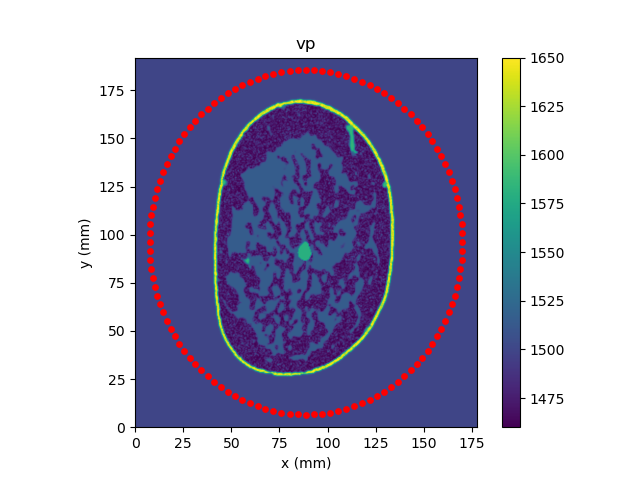

<IPython.core.display.Javascript object>


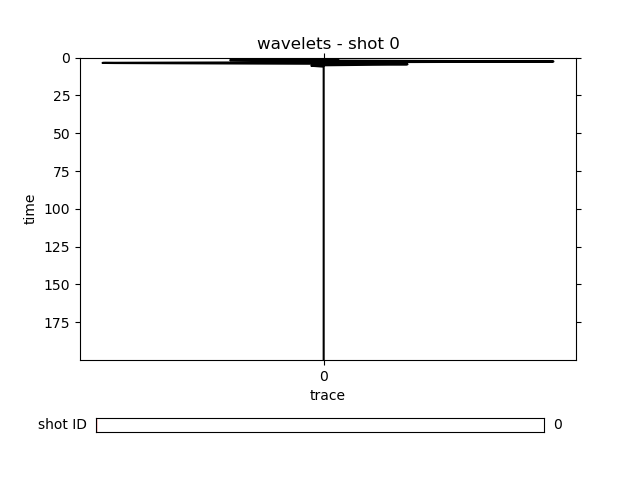

In [7]:
# Plot all components of the problem
problem.plot()

## Modelling operator

Once we have generated our problem, we can create a PDE on which to run our forward problem. In this case, we choose the isotropic acoustic wave equation.

We instantiate our PDE using `remote(len=<num>)` so that instances of the PDE are created in the workers for remote execution. We choose `len=runtime.num_workers` so that one instance is created in each available worker.

In [8]:
from stride import IsoAcousticDevito

pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

WORKER:0:0      Default Devito configuration:
WORKER:0:0      	 * autotuning=['aggressive', 'runtime']
WORKER:0:0      	 * develop-mode=False
WORKER:0:0      	 * mpi=False
WORKER:0:0      	 * log-level=DEBUG
WORKER:0:0      	 * language=openmp
WORKER:0:1      Default Devito configuration:
WORKER:0:1      	 * autotuning=['aggressive', 'runtime']
WORKER:0:1      	 * develop-mode=False
WORKER:0:1      	 * mpi=False
WORKER:0:1      	 * log-level=DEBUG
WORKER:0:1      	 * language=openmp
WORKER:0:2      Default Devito configuration:
WORKER:0:2      	 * autotuning=['aggressive', 'runtime']
WORKER:0:2      	 * develop-mode=False
WORKER:0:2      	 * mpi=False
WORKER:0:2      	 * log-level=DEBUG
WORKER:0:2      	 * language=openmp
WORKER:0:3      Default Devito configuration:
WORKER:0:3      	 * autotuning=['aggressive', 'runtime']
WORKER:0:3      	 * develop-mode=False
WORKER:0:3      	 * mpi=False
WORKER:0:3      	 * log-level=DEBUG
WORKER:0:3      	 * language=openmp


## Forward problem - Generating observed data

Before we can proceed with the imaging bit, we need to simulate the acquisition of some observed data.

Here, we will exploit the parallelisation capabilities of Mosaic to run different shots in parallel in each available worker. We do this with an asynchronous for loop using `@runtime.async_for(<iterable>)`. In the previous code section, the async function `loop()` is called as many times as there are shots in the acquisitions and, for each shot, it is assigned a worker.

HEAD            Giving shot 0 to worker:0:0
HEAD            Giving shot 1 to worker:0:1
HEAD            Giving shot 2 to worker:0:2
HEAD            Giving shot 3 to worker:0:3
WORKER:0:0      (ShotID 0) Preparing to run state for shot
WORKER:0:0      (ShotID 0) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 0) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 0) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 0) Selected undersampling level 4
WORKER:0:0      (ShotID 0) Selected time stepping scheme OT2
WORKER:0:0      Operator `acoustic_iso_state` instance configuration:
WORKER:0:0      	 * subs={h_x: 0.0005, h_y: 0.0005}
WORKER:0:0      	 * opt=advanced
WORKER:0:0      	 * platform=None
WORKER:0:0      Operator `acoustic_iso_state` generated in 1.92 s
WORKER:0:0        * lowering.Clusters: 0.65 s (34.0 %)
WORKER:0:0        * lowering

WORKER:0:2      (ShotID 2) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:2      (ShotID 2) Selected undersampling level 4
WORKER:0:2      (ShotID 2) Selected time stepping scheme OT2
WORKER:0:2      Operator `acoustic_iso_state` instance configuration:
WORKER:0:2      	 * subs={h_x: 0.0005, h_y: 0.0005}
WORKER:0:2      	 * opt=advanced
WORKER:0:2      	 * platform=None
WORKER:0:2      Operator `acoustic_iso_state` generated in 1.82 s
WORKER:0:2        * lowering.Clusters: 0.66 s (36.4 %)
WORKER:0:2           * specializing.Clusters: 0.37 s (20.4 %)
WORKER:0:2        * lowering.Expressions: 0.65 s (35.8 %)
WORKER:0:2        * lowering.IET: 0.45 s (24.8 %)
WORKER:0:2      Flops reduction after symbolic optimization: [317 --> 210]
WORKER:0:2      Operator `acoustic_iso_state` fetched `/tmp/devito-jitcache-uid1000/18cf852662cf067a01a8778c144d4f712f822ff3.c` in 1.16 s from jit-cache
WORKER:0:2      (ShotID 2) Running state equation for shot
WORKER:0:2      AutoTu

WORKER:0:3      (ShotID 9) Selected undersampling level 4
WORKER:0:3      (ShotID 9) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 9) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.89 s
WORKER:0:3      Global performance: [OI=2.28, 23.27 GFlops/s, 0.63 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.88 s [OI=2.27, 23.54 GFlops/s, 0.64 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.74 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 9) Completed state equation run for shot
WORKER:0:1      (ShotI

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 14) Completed state equation run for shot
HEAD            Shot 14 retrieved
HEAD            Retrieved traces for shot 14
HEAD            Giving shot 18 to worker:0:1
WORKER:0:0      (ShotID 15) Preparing to run state for shot
WORKER:0:0      (ShotID 15) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 15) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 15) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 15) Selected undersampling level 4
WORKER:0:0      (ShotID 15) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 15) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.78 s
WORKER:0:0      Global performance: [OI=2.28, 26.

WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.75 s
WORKER:0:2      Global performance: [OI=2.28, 27.55 GFlops/s, 0.75 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.74 s [OI=2.27, 27.88 GFlops/s, 0.76 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.00 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 20) Completed state equation run for shot
HEAD            Shot 20 retrieved
HEAD            Retrieved traces for shot 20
HEAD            Giving shot 24 to worker:0:2
WORKER:0:3      (ShotID 21) Preparing to run state for shot
WORKER:0:3     

HEAD            Retrieved traces for shot 25
HEAD            Giving shot 29 to worker:0:3
WORKER:0:1      (ShotID 26) Preparing to run state for shot
WORKER:0:1      (ShotID 26) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 26) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 26) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 26) Selected undersampling level 4
WORKER:0:1      (ShotID 26) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 26) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.62 s
WORKER:0:1      Global performance: [OI=2.28, 33.42 GFlops/s, 0.90 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.61 s [OI=2.27, 33.86 GFl

WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.62 s [OI=2.27, 33.53 GFlops/s, 0.91 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.15 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 31) Completed state equation run for shot
HEAD            Shot 31 retrieved
HEAD            Retrieved traces for shot 31
HEAD            Giving shot 35 to worker:0:0
WORKER:0:2      (ShotID 32) Preparing to run state for shot
WORKER:0:2      (ShotID 32) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 32) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm

WORKER:0:3      (ShotID 37) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:3      (ShotID 37) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:3      (ShotID 37) Selected undersampling level 4
WORKER:0:3      (ShotID 37) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 37) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.78 s
WORKER:0:3      Global performance: [OI=2.28, 26.58 GFlops/s, 0.72 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.77 s [OI=2.27, 26.90 GFlops/s, 0.73 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>

WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.92 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 42) Completed state equation run for shot
HEAD            Shot 42 retrieved
HEAD            Retrieved traces for shot 42
HEAD            Giving shot 46 to worker:0:1
WORKER:0:0      (ShotID 43) Preparing to run state for shot
WORKER:0:0      (ShotID 43) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 43) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 43) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 43) Selected undersampling level 4
WORKER:0:0      (ShotID 43) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 43) Running state equation for shot
WORKER:0:0      AutoTuner: c

WORKER:0:2      (ShotID 48) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 48) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.71 s
WORKER:0:2      Global performance: [OI=2.28, 29.25 GFlops/s, 0.79 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.70 s [OI=2.27, 29.63 GFlops/s, 0.80 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.20 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 48) Completed state equation run for shot
HEAD            Shot 48 retrieved
HEAD            Retrieved traces for shot 4

WORKER:0:3      (ShotID 53) Completed state equation run for shot
HEAD            Shot 53 retrieved
HEAD            Retrieved traces for shot 53
HEAD            Giving shot 57 to worker:0:3
WORKER:0:1      (ShotID 54) Preparing to run state for shot
WORKER:0:1      (ShotID 54) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 54) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 54) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 54) Selected undersampling level 4
WORKER:0:1      (ShotID 54) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 54) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.76 s
WORKER:0:1      Global performance: [OI=2.28, 27.32 GFlops/s, 0.74 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499

WORKER:0:0      Global performance: [OI=2.28, 30.96 GFlops/s, 0.84 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.66 s [OI=2.27, 31.52 GFlops/s, 0.85 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.19 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 59) Completed state equation run for shot
HEAD            Shot 59 retrieved
HEAD            Retrieved traces for shot 59
HEAD            Giving shot 63 to worker:0:0
WORKER:0:2      (ShotID 60) Preparing to run state for shot
WORKER:0:2      (ShotID 60) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 60) Spatial gr

WORKER:0:3      (ShotID 65) Preparing to run state for shot
WORKER:0:3      (ShotID 65) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 65) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:3      (ShotID 65) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:3      (ShotID 65) Selected undersampling level 4
WORKER:0:3      (ShotID 65) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 65) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.65 s
WORKER:0:3      Global performance: [OI=2.28, 31.79 GFlops/s, 0.86 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.64 s [OI=2.27, 32.21 GFlops/s, 0.87 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.12 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 70) Completed state equation run for shot
HEAD            Shot 70 retrieved
HEAD            Retrieved traces for shot 70
HEAD            Giving shot 74 to worker:0:1
WORKER:0:0      (ShotID 71) Preparing to run state for shot
WORKER:0:0      (ShotID 71) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 71) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 71) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 71) Selected undersampling level 4
WORKER:0:0      (ShotID

WORKER:0:2      (ShotID 76) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:2      (ShotID 76) Selected undersampling level 4
WORKER:0:2      (ShotID 76) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 76) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.65 s
WORKER:0:2      Global performance: [OI=2.28, 32.02 GFlops/s, 0.87 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.64 s [OI=2.27, 32.45 GFlops/s, 0.88 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.25 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaff

WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 81) Completed state equation run for shot
WORKER:0:1      (ShotID 82) Preparing to run state for shot
WORKER:0:1      (ShotID 82) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 82) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 82) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 82) Selected undersampling level 4
WORKER:0:1      (ShotID 82) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 82) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.68 s
WORKER:0:1      Global performance: [OI=2.28, 30.59 GFlops/s, 0.83 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499

WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.76 s
WORKER:0:0      Global performance: [OI=2.28, 27.16 GFlops/s, 0.74 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.75 s [OI=2.27, 27.48 GFlops/s, 0.75 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.99 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 87) Completed state equation run for shot
HEAD            Shot 87 retrieved
HEAD            Retrieved traces for shot 87
HEAD            Giving shot 91 to worker:0:0
WORKER:0:2      (ShotID 88) Preparing to run state for shot
WORKER:0:2     

HEAD            Retrieved traces for shot 92
HEAD            Giving shot 96 to worker:0:2
WORKER:0:3      (ShotID 93) Preparing to run state for shot
WORKER:0:3      (ShotID 93) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 93) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:3      (ShotID 93) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:3      (ShotID 93) Selected undersampling level 4
WORKER:0:3      (ShotID 93) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 93) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.69 s
WORKER:0:3      Global performance: [OI=2.28, 30.14 GFlops/s, 0.82 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.68 s [OI=2.27, 30.51 GFl

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.73 s [OI=2.27, 28.46 GFlops/s, 0.77 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.15 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 98) Completed state equation run for shot
HEAD            Shot 98 retrieved
HEAD            Retrieved traces for shot 98
HEAD            Giving shot 102 to worker:0:1
WORKER:0:0      (ShotID 99) Preparing to run state for shot
WORKER:0:0      (ShotID 99) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 99) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 m

WORKER:0:2      (ShotID 104) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 104) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:2      (ShotID 104) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:2      (ShotID 104) Selected undersampling level 4
WORKER:0:2      (ShotID 104) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 104) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.71 s
WORKER:0:2      Global performance: [OI=2.28, 29.15 GFlops/s, 0.79 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.70 s [OI=2.27, 29.55 GFlops/s, 0.80 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/

WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.67 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 109) Completed state equation run for shot
HEAD            Shot 109 retrieved
HEAD            Retrieved traces for shot 109
HEAD            Giving shot 113 to worker:0:3
WORKER:0:1      (ShotID 110) Preparing to run state for shot
WORKER:0:1      (ShotID 110) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 110) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 110) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 110) Selected undersampling level 4
WORKER:0:1    

WORKER:0:0      (ShotID 115) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 115) Selected undersampling level 4
WORKER:0:0      (ShotID 115) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 115) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.70 s
WORKER:0:0      Global performance: [OI=2.28, 29.62 GFlops/s, 0.80 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.69 s [OI=2.27, 29.99 GFlops/s, 0.81 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.17 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_no

<IPython.core.display.Javascript object>


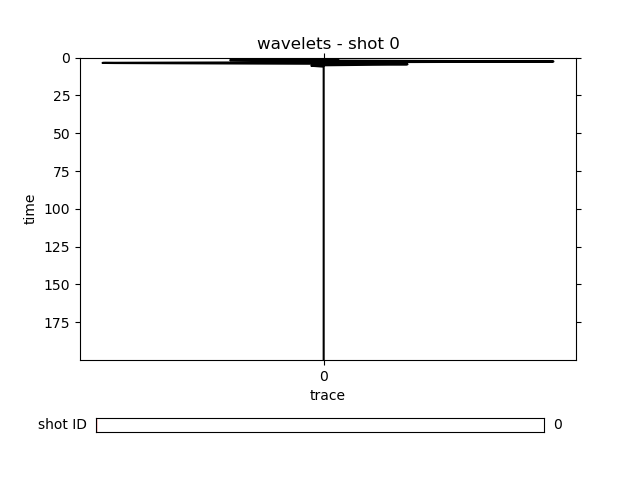

<IPython.core.display.Javascript object>


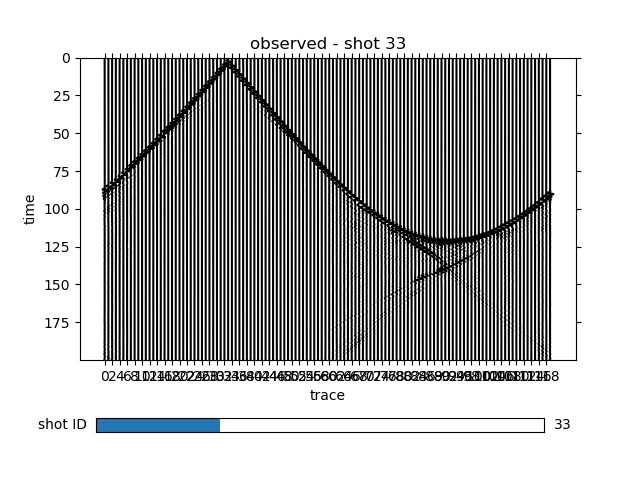

In [9]:
# Get all remaining shot IDs
shot_ids = problem.acquisitions.remaining_shot_ids

# Run an asynchronous loop across all shot IDs
@runtime.async_for(shot_ids)
async def loop(worker, shot_id):
    runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

    # Fetch one sub-problem corresponding to a shot ID
    sub_problem = problem.sub_problem(shot_id)
    
    # Access the source wavelets of this shot
    wavelets = sub_problem.shot.wavelets
    
    # Execute the PDE forward
    traces = await pde(wavelets, vp_true,
                       problem=sub_problem,
                       runtime=worker).result()

    runtime.logger.info('Shot %d retrieved' % sub_problem.shot_id)

    # Store the retrieved traces into the shot
    shot = problem.acquisitions.get(shot_id)
    shot.observed.data[:] = traces.data

    runtime.logger.info('Retrieved traces for shot %d' % sub_problem.shot_id)

# Because this is an asynchronous loop, it needs to be awaited 
_ = await loop

# Plot the result
_ = problem.acquisitions.plot()

Because the loop we just ran is a very common piece of code, we can obtain the same result by running the utility function `forward()`:

In [ ]:
from stride import forward

# Run default forward workflow
# await forward(problem, pde, vp_true, dump=False)  # uncomment to run using utility function

## Starting model

Before we can proceed with the imaging process, we need to determine a starting point for our inversion, a starting model.

In [10]:
vp = ScalarField.parameter(name='vp', grid=grid, needs_grad=True)
vp.fill(1500.)

problem.medium.add(vp)

Unlike our forward example, the speed-of-sound field is unknown to us at this point. So, we define our starting guess for the speed of sound to be homogeneous with a value of 1500 m/s. Because we are going to run our inversion with respect to `vp`, we also define the field with `needs_grad=True`. That will instruct Stride to calculate the gradient of this variable when running the optimisation loop.

You can also see that the field has now been instantiated using `parameter()`. This will turn `vp` into a remotely addressable object. What this means is that, as `vp` travels through our Mosaic network, it will always keep a reference to its original object here in our code. This will effectively allow us to accumulate the gradients calculated across different workers into a single local buffer.

## Imaging operators

Apart from our PDE operator, which we have already defined above, we will need to define an operator for our loss function:

In [11]:
from stride import L2DistanceLoss 

loss = L2DistanceLoss.remote(len=runtime.num_workers)

We will also need some operators to proprocess the source wavelents and the modelled and observed data traces:

In [12]:
from stride import ProcessWavelets, ProcessTraces

process_wavelets = ProcessWavelets.remote(len=runtime.num_workers)
process_traces = ProcessTraces.remote(len=runtime.num_workers)

Finally, we will need an optimiser to update the speed of sound model after each iteration. In this case, we use gradient descent.

In [13]:
from stride import GradientDescent, ProcessGlobalGradient, ProcessModelIteration

step_size = 10
process_grad = ProcessGlobalGradient()
process_model = ProcessModelIteration(min=1400., max=1700.)

optimiser = GradientDescent(vp, step_size=step_size,
                            process_grad=process_grad,
                            process_model=process_model)

You can see that we have also provided to the optimiser some pre-defined processing steps. These will be used to prepare the gradient before updating the variable, and to process the variable after the update. 

Among other things, these processing steps will normalise and smooth the gradient, and will clip the speed of sound of the updated model between 1400 m/s and 1700 m/s.

## Inverse problem - Estimating speed of sound

We can now proceed to solve the inverse problem, that is finding the speed of sound that explains the data that we have generated above.

To obtain a better posed optimisation, we use a multi-scale approach. We will start our inversion by using only low frequencies to construct our model. As the inversion progresses, we will add higher frequencies until we reach the maximum desired level of detail.

We can do this by dividing our optimisation in `Block`s and specifying a maximum frequency. Each `Block` will run for a number of specified iterations.

During each iteration, only a subset of the shots will be used by defining the `select_shots` field. In this case, 15 shots will be used for each iteration, and they will be selected randomly without replacement.

HEAD            Starting iteration 1 (out of 8), block 1 (out of 4)
HEAD            Giving shot 28 to worker:0:0
HEAD            Giving shot 31 to worker:0:1
HEAD            Giving shot 35 to worker:0:2
HEAD            Giving shot 39 to worker:0:3
WORKER:0:2      (ShotID 35) Preparing to run state for shot
WORKER:0:2      (ShotID 35) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 35) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:2      (ShotID 35) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:2      (ShotID 35) Selected undersampling level 4
WORKER:0:2      (ShotID 35) Selected time stepping scheme OT2
WORKER:0:2      Operator `acoustic_iso_state` instance configuration:
WORKER:0:2      	 * subs={h_x: 0.0005, h_y: 0.0005}
WORKER:0:2      	 * opt=advanced
WORKER:0:2      	 * platform=None
WORKER:0:2      Operator `acoustic_iso_state` generated in 1.67 s
WORKE

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.05 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 31) Completed state equation run for shot
HEAD            Functional value for shot 35: loss 4.147601e+00 for shot 35
HEAD            Functional value for shot 28: loss 4.565278e+00 for shot 28
HEAD            Functional value for shot 39: loss 3.320773e+00 for shot 39
HEAD            Functional value for shot 31: loss 3.425957e+00 for shot 31
WORKER:0:2      (ShotID 35) Preparing to run adjoint for shot
WORKER:0:2      Operator `acoustic_iso_adjoint` instance configuration:
WORKER:0:2      	 * subs={h_x: 0.0005, h_y: 0.0005}
WORKER:0:2      	 * opt=advanced
WORKER:0:2      	 * platform=None
WORKER:0:2      Oper

WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.04 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 41) Completed state equation run for shot
HEAD            Retrieved gradient for shot 28
HEAD            Giving shot 49 to worker:0:0
HEAD            Runtime head does not own object tess-scalarfield-ecd4c43c36c24363bf98d6ad4fc05068 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-9e0fcac89706476589b7928f7907949b of type tessera
HEAD            Functional value for shot 41: loss 2.246623e+00 for shot 41
WORKER:0:3      (ShotID 48) Preparing to run state for shot
WORKER:0:3      (ShotID 48) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 48) 

WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.84 s
WORKER:0:2      (ShotID 56) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.91 s
WORKER:0:0      Global performance: [OI=1.62, 34.53 GFlops/s, 0.67 GPts/s]
WORKER:0:2      (ShotID 56) Selected undersampling level 4
WORKER:0:1      Global performance: [OI=1.62, 31.74 GFlops/s, 0.61 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:2      (ShotID 56) Selected time stepping scheme OT2
WORKER:0:1      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.63 s [OI=2.27, 32.60 GFlops/s, 0.88 GPts/s]
WORKER:0:2      (ShotID 56) Running state equation for shot
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.70 s [OI=2.27, 29.39 GFlops/s, 0.80 GPts/s]
WORKER:0:0        * 

HEAD            Runtime head does not own object tess-scalarfield-c70814e919124065bf508c461f6f7cfd of type tessera
HEAD            Functional value for shot 68: loss 2.430323e+00 for shot 68
WORKER:0:3      (ShotID 57) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 57) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.73 s
WORKER:0:3      Global performance: [OI=1.62, 39.51 GFlops/s, 0.76 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.55 s [OI=2.27, 37.82 GFlops/s, 1.02 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.40 GFlops/s, 0.04 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.18 s [OI=0.94, 46.85 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaf

WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.85 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 107) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-1a1d8e8ae6274deaacecfa474bd6389e of type tessera
HEAD            Runtime head does not own object tess-scalarfield-867f24ae6c314e86b72906664681edc1 of type tessera
HEAD            Functional value for shot 97: loss 2.926769e+00 for shot 97
HEAD            Retrieved gradient for shot 92
HEAD            Runtime head does not own object tess-scalarfield-f35d1c81b0da4312bee0ce138218ec05 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-3c8cda8cfd9044b9b0a0ea21cd3af4a5 of type t

WORKER:0:1      (ShotID 3) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 3) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.35 s
WORKER:0:1      Global performance: [OI=2.28, 15.25 GFlops/s, 0.42 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.27 s [OI=2.27, 16.26 GFlops/s, 0.44 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 0.96 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 3) Completed state equation run for shot
HEAD            Functional value for shot 19: loss 2.237098e+00 for shot 19
HEAD

WORKER:0:3      (ShotID 23) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.57 s
WORKER:0:3      Global performance: [OI=1.62, 51.04 GFlops/s, 0.98 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.06 GFlops/s, 1.30 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.70 GFlops/s, 0.04 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.13 s [OI=0.94, 64.00 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 23) Completed adjoint equation run for shot
WORKER:0:2      (ShotID 46) Preparing to run state for shot
WORKER:0:2      (ShotID 46) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 

WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 58) Completed state equation run for shot
HEAD            Functional value for shot 58: loss 1.889639e+00 for shot 58
HEAD            Retrieved gradient for shot 46
HEAD            Giving shot 73 to worker:0:2
WORKER:0:0      (ShotID 70) Preparing to run state for shot
WORKER:0:0      (ShotID 70) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 70) Spatial grid spacing (0.500 mm | 4.054 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:0      (ShotID 70) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:0      (ShotID 70) Selected undersampling level 4
WORKER:0:0      (ShotID 70) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 70) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.44 s
WORKE

WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 73) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 70
HEAD            Giving shot 109 to worker:0:0
WORKER:0:3      (ShotID 103) Preparing to run state for shot
WORKER:0:3      (ShotID 103) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 103) Spatial grid spacing (0.500 mm | 4.054 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:3      (ShotID 103) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:3      (ShotID 103) Selected undersampling level 4
WORKER:0:3      (ShotID 103) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 103) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:3      Global performance: [OI=2.28, 44.33 GFlops/s, 1.20 GPts

WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 48.88 GFlops/s, 1.32 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.82 GFlops/s, 0.05 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.10 s [OI=0.94, 88.93 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 117) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 117
HEAD            Updating variable vp,
HEAD            	 direction before processing in range [-7.563715e-05, 6.809430e-05]
HEAD            	 direction after processing in range [-1.000000e+00, 9.002073e-01]
HEAD            	 variable range before update [1.490000e+03, 1.506992e+03]
HEAD            	 variable range after update [1.488097e+03, 1.512894e+03]
HEAD            Done 

WORKER:0:1      (ShotID 30) Running adjoint equation for shot
WORKER:0:0      (ShotID 11) Running adjoint equation for shot
WORKER:0:2      (ShotID 36) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.66 s
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.66 s
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 1.63 s
WORKER:0:1      Global performance: [OI=1.62, 17.42 GFlops/s, 0.34 GPts/s]
WORKER:0:0      Global performance: [OI=1.62, 17.39 GFlops/s, 0.34 GPts/s]
WORKER:0:2      Global performance: [OI=1.62, 17.78 GFlops/s, 0.35 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:0      Local performance:
WORKER:0:2      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.30 s [OI=2.27, 15.81 GFlop

HEAD            Runtime head does not own object tess-scalarfield-916453a330fb48a5be5dcef0b5930ae2 of type tessera
HEAD            Functional value for shot 62: loss 1.485348e+00 for shot 62
HEAD            Retrieved gradient for shot 59
HEAD            Giving shot 79 to worker:0:3
HEAD            Runtime head does not own object tess-scalarfield-213f379340b84543888c970ff1b1b8df of type tessera
HEAD            Runtime head does not own object tess-scalarfield-79f1f2e3f9f14197995ddedee65518d8 of type tessera
HEAD            Functional value for shot 77: loss 1.738806e+00 for shot 77
WORKER:0:2      (ShotID 78) Preparing to run state for shot
WORKER:0:2      (ShotID 78) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 78) Spatial grid spacing (0.500 mm | 4.049 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:2      (ShotID 78) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:2      (ShotID 78) Selected und

WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.32 GFlops/s, 0.03 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.22 s [OI=0.94, 38.53 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 79) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 78
HEAD            Giving shot 85 to worker:0:2
WORKER:0:1      (ShotID 80) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 83) Preparing to run state for shot
WORKER:0:1      (ShotID 80) Running adjoint equation for shot
WORKER:0:0      (ShotID 83) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 83) Spatial grid spacing (0.500 mm | 4.049 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.59 s
WORKER:

WORKER:0:1      (ShotID 93) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-dca181524596408fa677ae31d5faf633 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-29355e7c159347b69ebcf2b29e208537 of type tessera
HEAD            Functional value for shot 86: loss 2.514593e+00 for shot 86
WORKER:0:2      (ShotID 85) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 85) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.61 s
WORKER:0:2      Global performance: [OI=1.62, 47.49 GFlops/s, 0.92 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.46 s [OI=2.27, 45.55 GFlops/s, 1.23 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.73 GFlops/s, 

WORKER:0:2      (ShotID 10) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 1.21 s
WORKER:0:2      Global performance: [OI=2.28, 16.97 GFlops/s, 0.46 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.13 s [OI=2.27, 18.29 GFlops/s, 0.50 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.29 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 10) Completed state equation run for shot
WORKER:0:1      (ShotID 9) Preparing to run state for shot
WORKER:0:1      (ShotID 9) Estimated bandwidth for the propagated wavelet 0.255-

WORKER:0:2      Global performance: [OI=2.28, 46.83 GFlops/s, 1.27 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=2.27, 50.71 GFlops/s, 1.37 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.90 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 24) Completed state equation run for shot
HEAD            Retrieved gradient for shot 9
HEAD            Giving shot 60 to worker:0:1
HEAD            Runtime head does not own object tess-scalarfield-158134daf4944f54b7b4da8b01e79637 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-cf0f70facc9e47039af7bd36e99b6ab3 of type 

WORKER:0:3      (ShotID 65) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:2      (ShotID 66) Spatial grid spacing (0.500 mm | 4.041 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.73 s
WORKER:0:2      (ShotID 66) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.66 s
WORKER:0:1      Global performance: [OI=1.62, 39.94 GFlops/s, 0.77 GPts/s]
WORKER:0:2      (ShotID 66) Selected undersampling level 4
WORKER:0:3      Global performance: [OI=1.62, 44.24 GFlops/s, 0.85 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:2      (ShotID 66) Selected time stepping scheme OT2
WORKER:0:3      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.55 s [OI=2.27, 37.93 GFlops/s, 1.03

WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.92 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 88) Completed state equation run for shot
WORKER:0:0      (ShotID 69) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 69) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.65 s
WORKER:0:0      Global performance: [OI=1.62, 44.49 GFlops/s, 0.86 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.49 s [OI=2.27, 42.18 GFlops/s, 1.14 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 119) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-a31ad404b356418ea63803ebf60c9506 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-24c5336dc19d4b04aa51b3da7c30ae9e of type tessera
HEAD            Functional value for shot 113: loss 1.447765e+00 for shot 113
HEAD            Retrieved gradient for shot 90
HEAD            Runtime head does not own object tess-scalarfield-2955c084d4ec4290a41356249fe3158b of type tessera
HEAD            Runtime head does not own object tess-scalarfield-82782c116bfd465bab8eeed3bc7dc004 of type tessera
HEAD            Functional value for shot 119: loss 1.660441e+00 for shot 119
WORKER:0:0      (ShotID 113) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 113) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any 

WORKER:0:1      Global performance: [OI=2.28, 17.30 GFlops/s, 0.47 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.10 s [OI=2.27, 18.77 GFlops/s, 0.51 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.02 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.40 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 8) Completed state equation run for shot
HEAD            Functional value for shot 18: loss 1.393335e+00 for shot 18
HEAD            Functional value for shot 21: loss 1.887403e+00 for shot 21
HEAD            Functional value for shot 1: loss 1.339481e+00 for shot 1
HEAD            Functional value for shot 8: loss 1.169999e+00 for shot 8
WORKER:0:2    

WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.45 GFlops/s, 1.31 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.80 GFlops/s, 0.04 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 62.29 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 22) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 45) Preparing to run state for shot
WORKER:0:3      (ShotID 45) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 45) Spatial grid spacing (0.500 mm | 4.040 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:3      (ShotID 45) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:3      (ShotID 45) Selected undersampling level 

HEAD            Retrieved gradient for shot 45
HEAD            Giving shot 95 to worker:0:3
WORKER:0:0      (ShotID 94) Preparing to run state for shot
WORKER:0:0      (ShotID 94) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 94) Spatial grid spacing (0.500 mm | 4.040 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:0      (ShotID 94) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:0      (ShotID 94) Selected undersampling level 4
WORKER:0:0      (ShotID 94) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 94) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:0      Global performance: [OI=2.28, 47.25 GFlops/s, 1.28 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=2.27, 51.21 G

WORKER:0:2      (ShotID 101) Preparing to run state for shot
WORKER:0:2      (ShotID 101) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 101) Spatial grid spacing (0.500 mm | 4.040 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:2      (ShotID 101) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:2      (ShotID 101) Selected undersampling level 4
WORKER:0:2      (ShotID 101) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 101) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:2      Global performance: [OI=2.28, 44.05 GFlops/s, 1.19 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=2.27, 47.68 GFlops/s, 1.29 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1

WORKER:0:3        * section2<2499,456,485> ran in 0.13 s [OI=0.94, 68.37 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 112) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 104
HEAD            Retrieved gradient for shot 112
HEAD            Updating variable vp,
HEAD            	 direction before processing in range [-7.920236e-05, 6.896479e-05]
HEAD            	 direction after processing in range [-1.000000e+00, 8.702503e-01]
HEAD            	 variable range before update [1.484773e+03, 1.521894e+03]
HEAD            	 variable range after update [1.480043e+03, 1.526660e+03]
HEAD            Done iteration 5 (out of 8), block 1 (out of 4) - Total loss_freq 2.313083e+01
HEAD            ====================================================================
HEAD            Starting iteration 6 (out of 8), block 1 (out of 4)
HEAD            Giving shot 5 to worker:0:0
HEAD   

WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.72 GFlops/s, 0.02 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.32 s [OI=0.94, 26.23 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 20) Completed adjoint equation run for shot
WORKER:0:1      (ShotID 7) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 7) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.55 s
WORKER:0:1      Global performance: [OI=1.62, 18.61 GFlops/s, 0.36 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.22 s [OI=2.27, 16.95 GFlops/s, 0.46 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.70 G

WORKER:0:0      (ShotID 54) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 54) Spatial grid spacing (0.500 mm | 4.027 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:0      (ShotID 54) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:0      (ShotID 54) Selected undersampling level 4
WORKER:0:0      (ShotID 54) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 54) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.48 s
WORKER:0:0      Global performance: [OI=2.28, 42.86 GFlops/s, 1.16 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.45 s [OI=2.27, 46.48 GFlops/s, 1.26 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WOR

WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.47 s [OI=2.27, 43.68 GFlops/s, 1.18 GPts/s]
WORKER:0:1      (ShotID 89) Spatial grid spacing (0.500 mm | 4.027 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.64 GFlops/s, 0.04 GPts/s]
WORKER:0:1      (ShotID 89) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:2        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 51.90 GFlops/s]
WORKER:0:1      (ShotID 89) Selected undersampling level 4
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 89) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 61) Completed adjoint equation run for shot
WORKER:0:1      (ShotID 89) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0

WORKER:0:3      (ShotID 106) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 105) Running adjoint equation for shot
WORKER:0:3      (ShotID 106) Spatial grid spacing (0.500 mm | 4.027 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:3      (ShotID 106) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.75 s
WORKER:0:3      (ShotID 106) Selected undersampling level 4
WORKER:0:2      Global performance: [OI=1.62, 38.65 GFlops/s, 0.75 GPts/s]
WORKER:0:3      (ShotID 106) Selected time stepping scheme OT2
WORKER:0:2      Local performance:
WORKER:0:3      (ShotID 106) Running state equation for shot
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.58 s [OI=2.27, 35.57 GFlops/s, 0.96 GPts/s]
WORKER:0:3      AutoTuner: could not perform any runs
WORKE

WORKER:0:3      (ShotID 15) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:3      (ShotID 15) Selected undersampling level 4
WORKER:0:3      (ShotID 15) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 15) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 1.12 s
WORKER:0:3      Global performance: [OI=2.28, 18.36 GFlops/s, 0.50 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.05 s [OI=2.27, 19.54 GFlops/s, 0.53 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.43 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaff

WORKER:0:0      (ShotID 25) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 25) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:0      Global performance: [OI=2.28, 47.67 GFlops/s, 1.29 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.40 s [OI=2.27, 51.75 GFlops/s, 1.40 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.14 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 25) Completed state equation run for shot
HEAD            Retrieved gradient for shot 4
HEAD            Giving shot 37 

WORKER:0:2      (ShotID 50) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 37) Running adjoint equation for shot
WORKER:0:0      (ShotID 84) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 50) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 84) Spatial grid spacing (0.500 mm | 4.027 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.71 s
WORKER:0:0      (ShotID 84) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.63 s
WORKER:0:1      Global performance: [OI=1.62, 40.99 GFlops/s, 0.79 GPts/s]
WORKER:0:0      (ShotID 84) Selected undersampling level 4
WORKER:0:2      Global performance: [OI=1.62, 46.40 GFlops/s, 0.89 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:0      (ShotID 84)

WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.99 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 102) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-2d181946e59549c0835596b7ac87968a of type tessera
HEAD            Runtime head does not own object tess-scalarfield-325e86077e78443ba6e2b1477b01f612 of type tessera
HEAD            Functional value for shot 91: loss 1.314281e+00 for shot 91
WORKER:0:3      (ShotID 87) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 87) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.64 s
WORKER:0:3      Global perform

WORKER:0:1      (ShotID 116) Selected undersampling level 4
WORKER:0:1      (ShotID 116) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 116) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:1      Global performance: [OI=2.28, 43.78 GFlops/s, 1.18 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=2.27, 47.17 GFlops/s, 1.28 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.01 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 116) Completed state equation run for shot
HEAD          

WORKER:0:2      (ShotID 33) Completed state equation run for shot
WORKER:0:1      (ShotID 27) Completed state equation run for shot
WORKER:0:0      (ShotID 16) Preparing to run state for shot
WORKER:0:0      (ShotID 16) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 16) Spatial grid spacing (0.500 mm | 4.019 PPW) is higher than dispersion limit (0.402 mm | 5.000 PPW)
WORKER:0:0      (ShotID 16) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:0      (ShotID 16) Selected undersampling level 4
WORKER:0:0      (ShotID 16) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 16) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.15 s
WORKER:0:0      Global performance: [OI=2.28, 17.94 GFlops/s, 0.49 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,

WORKER:0:0      (ShotID 43) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-30baa76d92bd4352aed01fc7b1c1d0b1 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-4954e821c7774813b8960c14dda5e244 of type tessera
HEAD            Functional value for shot 40: loss 1.195346e+00 for shot 40
HEAD            Retrieved gradient for shot 34
HEAD            Giving shot 64 to worker:0:3
WORKER:0:2      (ShotID 52) Preparing to run state for shot
WORKER:0:2      (ShotID 52) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 52) Spatial grid spacing (0.500 mm | 4.019 PPW) is higher than dispersion limit (0.402 mm | 5.000 PPW)
WORKER:0:2      (ShotID 52) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:2      (ShotID 52) Selected undersampling level 4
WORKER:0:2      (ShotID 52) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 52) Running state eq

WORKER:0:1      (ShotID 72) Completed state equation run for shot
HEAD            Retrieved gradient for shot 52
HEAD            Giving shot 76 to worker:0:2
WORKER:0:3      (ShotID 64) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 64) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.56 s
WORKER:0:3      Global performance: [OI=1.62, 52.38 GFlops/s, 1.01 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.49 GFlops/s, 1.34 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.87 GFlops/s, 0.05 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.13 s [OI=0.94, 64.67 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID

WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.42 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 81) Completed state equation run for shot
HEAD            Retrieved gradient for shot 74
HEAD            Giving shot 115 to worker:0:0
HEAD            Functional value for shot 81: loss 1.617416e+00 for shot 81
WORKER:0:1      (ShotID 100) Preparing to run state for shot
WORKER:0:1      (ShotID 100) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 100) Spatial grid spacing (0.500 mm | 4.019 PPW) is higher than dispersion limit (0.402 mm | 5.000 PPW)
WORKER:0:1      (ShotID 100) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:1      (ShotID 100) Sele

HEAD            Runtime head does not own object tess-scalarfield-7243de2bc3584c10b9844a499f6af4ce of type tessera
HEAD            Functional value for shot 118: loss 1.138487e+00 for shot 118
HEAD            Retrieved gradient for shot 100
WORKER:0:2      (ShotID 118) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 118) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.56 s
WORKER:0:2      Global performance: [OI=1.62, 51.60 GFlops/s, 0.99 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.70 GFlops/s, 1.32 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.80 GFlops/s, 0.04 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.13 s [OI=0.94, 64.02 GFlops/s]
WORKER:0:2      Performance[mode=

WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.72 GFlops/s, 0.02 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.30 s [OI=0.94, 28.40 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 9) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 18) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 18) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 1.46 s
WORKER:0:3      Global performance: [OI=1.62, 19.75 GFlops/s, 0.38 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.13 s [OI=2.27, 18.24 GFlops/s, 0.50 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.70 

WORKER:0:1      Operator `acoustic_iso_state` ran in 0.48 s
WORKER:0:1      Global performance: [OI=2.28, 43.50 GFlops/s, 1.18 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=2.27, 47.02 GFlops/s, 1.27 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.91 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 65) Completed state equation run for shot
HEAD            Retrieved gradient for shot 37
HEAD            Giving shot 81 to worker:0:0
HEAD            Runtime head does not own object tess-scalarfield-b4af64e369b849fcaeed44b85f115634 of type tessera
HEAD            Runtime head does not own obje

HEAD            Retrieved gradient for shot 66
HEAD            Giving shot 98 to worker:0:2
WORKER:0:0      (ShotID 81) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 81) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.56 s
WORKER:0:0      Global performance: [OI=1.62, 51.99 GFlops/s, 1.00 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.17 GFlops/s, 1.33 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.72 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.13 s [OI=0.94, 64.23 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 81) Completed adjoint equation run for shot
WORKER:0:1      (Shot

WORKER:0:2      (ShotID 98) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.57 s
WORKER:0:2      Global performance: [OI=1.62, 51.37 GFlops/s, 0.99 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 48.85 GFlops/s, 1.32 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.83 GFlops/s, 0.05 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 62.12 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 98) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 94
HEAD            Giving shot 112 to worker:0:1
HEAD            Functional value for shot 99: loss 1.089533e+00 for shot 99
WORKER

WORKER:0:1      (ShotID 10) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:1      (ShotID 10) Selected undersampling level 4
WORKER:0:1      (ShotID 10) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 10) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.04 s
WORKER:0:1      Global performance: [OI=2.28, 19.83 GFlops/s, 0.54 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.98 s [OI=2.27, 21.14 GFlops/s, 0.57 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.55 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaff

WORKER:0:3      (ShotID 36) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 1.41 s
WORKER:0:3      Global performance: [OI=1.62, 20.57 GFlops/s, 0.40 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.09 s [OI=2.27, 18.88 GFlops/s, 0.51 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.03 s [OI=2.82, 0.60 GFlops/s, 0.02 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.30 s [OI=0.94, 28.45 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 36) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 7
HEAD            Giving shot 46 to worker:0:0
WORKER:0:1      (ShotID 42) Preparing to run state for shot
WORKER:0:1      (ShotID 

HEAD            Runtime head does not own object tess-scalarfield-596301a02d844f069cd968c5907018ca of type tessera
HEAD            Functional value for shot 52: loss 9.933972e-01 for shot 52
HEAD            Functional value for shot 55: loss 1.236249e+00 for shot 55
WORKER:0:0      (ShotID 46) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 46) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.69 s
WORKER:0:0      Global performance: [OI=1.62, 42.14 GFlops/s, 0.81 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.52 s [OI=2.27, 40.03 GFlops/s, 1.08 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.48 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 51.18 GFlops/s]
WORKER:0:

HEAD            Runtime head does not own object tess-scalarfield-84a5c5f399774978985ea897724bacac of type tessera
HEAD            Runtime head does not own object tess-scalarfield-7916402c87fe4ed8a44f4f5619b7f2c1 of type tessera
HEAD            Functional value for shot 69: loss 1.267449e+00 for shot 69
HEAD            Retrieved gradient for shot 59
HEAD            Giving shot 111 to worker:0:1
WORKER:0:3      (ShotID 96) Preparing to run state for shot
WORKER:0:3      (ShotID 96) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 96) Spatial grid spacing (0.500 mm | 4.011 PPW) is higher than dispersion limit (0.401 mm | 5.000 PPW)
WORKER:0:3      (ShotID 96) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:3      (ShotID 96) Selected undersampling level 4
WORKER:0:3      (ShotID 96) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 96) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any 

HEAD            Retrieved gradient for shot 96
WORKER:0:1      (ShotID 111) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 111) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.58 s
WORKER:0:1      Global performance: [OI=1.62, 49.95 GFlops/s, 0.96 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=2.27, 47.24 GFlops/s, 1.28 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.78 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 61.48 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 111) Completed adjoint equation run for shot
WORKER:0:2      (ShotID 119) Preparing to run state for shot
WO

WORKER:0:3      (ShotID 24) Completed state equation run for shot
WORKER:0:2      (ShotID 20) Preparing to run state for shot
WORKER:0:2      (ShotID 20) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 20) Spatial grid spacing (0.500 mm | 4.014 PPW) is higher than dispersion limit (0.401 mm | 5.000 PPW)
WORKER:0:2      (ShotID 20) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:2      (ShotID 20) Selected undersampling level 4
WORKER:0:2      (ShotID 20) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 20) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 1.26 s
WORKER:0:2      Global performance: [OI=2.28, 16.33 GFlops/s, 0.44 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.17 s [OI=2.27, 17.56 GFlops/s, 0.48 GPts/s]
WORK

HEAD            Giving shot 33 to worker:0:1
HEAD            Runtime head does not own object tess-scalarfield-c0f79023ba4b4cb9916af3a1b0659392 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-d0bcb8adb60649ec8d0c3405e6a3bb51 of type tessera
HEAD            Functional value for shot 26: loss 1.681773e+00 for shot 26
WORKER:0:2      (ShotID 32) Preparing to run state for shot
WORKER:0:2      (ShotID 32) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 32) Spatial grid spacing (0.500 mm | 4.014 PPW) is higher than dispersion limit (0.401 mm | 5.000 PPW)
WORKER:0:2      (ShotID 32) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:2      (ShotID 32) Selected undersampling level 4
WORKER:0:2      (ShotID 32) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 32) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_stat

WORKER:0:1      Local performance:
WORKER:0:0      (ShotID 60) Selected time stepping scheme OT2
WORKER:0:3      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.49 s [OI=2.27, 42.08 GFlops/s, 1.14 GPts/s]
WORKER:0:0      (ShotID 60) Running state equation for shot
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.54 s [OI=2.27, 38.28 GFlops/s, 1.04 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.57 GFlops/s, 0.04 GPts/s]
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.48 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 53.94 GFlops/s]
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.54 s
WORKER:0:3        * section2<

WORKER:0:2      Global performance: [OI=1.62, 42.05 GFlops/s, 0.81 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.51 s [OI=2.27, 40.26 GFlops/s, 1.09 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.50 GFlops/s, 0.04 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 49.81 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 62) Completed adjoint equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-5a72e0b95b1347eebbff601aa4dd12b4 of type tessera
WORKER:0:1      (ShotID 70) Preparing to run adjoint for shot
HEAD            Runtime head does not own object tess-scalarfield-da627d2a0fcf457b95d579ca984430ba of type tessera
WORKER:0:1      (ShotID 70) Running adjoint equation for shot

HEAD            Runtime head does not own object tess-scalarfield-cea82a30971c4b598cd3931f9c5caf6d of type tessera
HEAD            Runtime head does not own object tess-scalarfield-bfad754e3cf4427598ae0f36891f823e of type tessera
HEAD            Functional value for shot 109: loss 1.116622e+00 for shot 109
HEAD            Retrieved gradient for shot 105
HEAD            Runtime head does not own object tess-scalarfield-76c3ca7bdb474591b91a43fbc56d6007 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-de3a55dca3da4d55b8bd7c4fa2af3ca8 of type tessera
HEAD            Functional value for shot 117: loss 6.887128e-01 for shot 117
WORKER:0:2      (ShotID 109) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 109) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.61 s
WORKER:0:2      Global performance: [OI=1.62, 47.98 GFlops/s, 0.93 GPts/s]
WORKER:0:2      Loc

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 0.69 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 28) Completed state equation run for shot
HEAD            Functional value for shot 38: loss 1.376745e+00 for shot 38
HEAD            Functional value for shot 0: loss 7.586649e-01 for shot 0
HEAD            Functional value for shot 29: loss 1.389946e+00 for shot 29
HEAD            Functional value for shot 28: loss 1.714394e+00 for shot 28
WORKER:0:3      (ShotID 38) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 38) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 1.49 s
WORKER:0:3      Global performance:

WORKER:0:3      Global performance: [OI=1.62, 51.31 GFlops/s, 0.99 GPts/s]
WORKER:0:1      (ShotID 54) Preparing to run state for shot
WORKER:0:3      Local performance:
WORKER:0:1      (ShotID 54) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.29 GFlops/s, 1.31 GPts/s]
WORKER:0:1      (ShotID 54) Spatial grid spacing (0.500 mm | 4.006 PPW) is higher than dispersion limit (0.401 mm | 5.000 PPW)
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.82 GFlops/s, 0.05 GPts/s]
WORKER:0:1      (ShotID 54) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:3        * section2<2499,456,485> ran in 0.13 s [OI=0.94, 64.16 GFlops/s]
WORKER:0:1      (ShotID 54) Selected undersampling level 4
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaff

WORKER:0:0      (ShotID 68) Spatial grid spacing (0.500 mm | 4.006 PPW) is higher than dispersion limit (0.401 mm | 5.000 PPW)
WORKER:0:0      (ShotID 68) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:0      (ShotID 68) Selected undersampling level 4
WORKER:0:0      (ShotID 68) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 68) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.43 s
WORKER:0:0      Global performance: [OI=2.28, 48.12 GFlops/s, 1.30 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.40 s [OI=2.27, 52.17 GFlops/s, 1.41 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>

WORKER:0:3      (ShotID 92) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:3      (ShotID 92) Selected undersampling level 4
WORKER:0:3      (ShotID 92) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 92) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.46 s
WORKER:0:3      Global performance: [OI=2.28, 45.05 GFlops/s, 1.22 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.00 GFlops/s, 1.33 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.06 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaff

HEAD            Retrieved gradient for shot 101
HEAD            Retrieved gradient for shot 116
HEAD            Updating variable vp,
HEAD            	 direction before processing in range [-1.190676e-04, 3.549677e-05]
HEAD            	 direction after processing in range [-1.000000e+00, 2.980547e-01]
HEAD            	 variable range before update [1.472232e+03, 1.544569e+03]
HEAD            	 variable range after update [1.473781e+03, 1.550008e+03]
HEAD            Done iteration 4 (out of 8), block 2 (out of 4) - Total loss_freq 1.793929e+01
HEAD            ====================================================================
HEAD            Starting iteration 5 (out of 8), block 2 (out of 4)
HEAD            Giving shot 1 to worker:0:0
HEAD            Giving shot 3 to worker:0:1
HEAD            Giving shot 4 to worker:0:2
HEAD            Giving shot 22 to worker:0:3
WORKER:0:1      (ShotID 3) Preparing to run state for shot
WORKER:0:1      (ShotID 3) Estimated bandwidth for the propaga

WORKER:0:2      (ShotID 4) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 22) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 22) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 1.61 s
WORKER:0:3      Global performance: [OI=1.62, 17.96 GFlops/s, 0.35 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.26 s [OI=2.27, 16.33 GFlops/s, 0.44 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.03 s [OI=2.82, 0.63 GFlops/s, 0.02 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.33 s [OI=0.94, 25.42 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 22) Completed adjoint equation run for shot
WORKER:0:0      (ShotID 1) Preparing to run ad

WORKER:0:0      (ShotID 44) Selected undersampling level 4
WORKER:0:0      (ShotID 44) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 44) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.45 s
WORKER:0:0      Global performance: [OI=2.28, 46.53 GFlops/s, 1.26 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=2.27, 50.56 GFlops/s, 1.37 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.07 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 44) Completed state equation run for shot
HEAD            Ru

WORKER:0:3      (ShotID 82) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.145 μs)
WORKER:0:3      (ShotID 82) Selected undersampling level 4
WORKER:0:3      (ShotID 82) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 82) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.49 s
WORKER:0:3      Global performance: [OI=2.28, 42.26 GFlops/s, 1.14 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.45 s [OI=2.27, 45.64 GFlops/s, 1.23 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.85 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaff

WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 106) Completed state equation run for shot
HEAD            Functional value for shot 106: loss 8.011057e-01 for shot 106
WORKER:0:0      (ShotID 87) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 87) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.75 s
WORKER:0:0      Global performance: [OI=1.62, 38.80 GFlops/s, 0.75 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.55 s [OI=2.27, 37.56 GFlops/s, 1.02 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.44 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.19 s [OI=0.94, 44.38 GFlops/s]
WORKER:0:0      Performance[mode=adv

WORKER:0:3      Global performance: [OI=2.28, 17.71 GFlops/s, 0.48 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.09 s [OI=2.27, 18.83 GFlops/s, 0.51 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.39 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 17) Completed state equation run for shot
WORKER:0:1      (ShotID 11) Preparing to run state for shot
WORKER:0:1      (ShotID 11) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 11) Spatial grid spacing (0.500 mm | 3.999 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:1      (ShotID 11) Time gr

WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.96 GFlops/s, 1.35 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.99 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 30) Completed state equation run for shot
HEAD            Retrieved gradient for shot 11
HEAD            Giving shot 40 to worker:0:1
HEAD            Runtime head does not own object tess-scalarfield-b1511f49dada409f92b84c55bcab5637 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-31828d5cd0f54c9783b22296f2f9cc9f of type tessera
HEAD            Functional value for shot 30: loss 1.958117e+00 for shot 30
WORKER:0:3      (ShotID 3

WORKER:0:2      (ShotID 51) Spatial grid spacing (0.500 mm | 3.999 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.76 s
WORKER:0:2      (ShotID 51) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.145 μs)
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.72 s
WORKER:0:1      Global performance: [OI=1.62, 38.15 GFlops/s, 0.74 GPts/s]
WORKER:0:2      (ShotID 51) Selected undersampling level 4
WORKER:0:0      Global performance: [OI=1.62, 40.57 GFlops/s, 0.78 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:2      (ShotID 51) Selected time stepping scheme OT2
WORKER:0:0      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.57 s [OI=2.27, 36.16 GFlops/s, 0.98 GPts/s]
WORKER:0:2      (ShotID 51) Running state equation for shot
WORKER:0:0        * section0<<2499,376,405>,<24

WORKER:0:0      (ShotID 104) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-604dac03651243e5b0bdb01d893d5157 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-ea45e7cedc114e5d897cc9e1176b7594 of type tessera
HEAD            Functional value for shot 77: loss 1.484388e+00 for shot 77
WORKER:0:3      (ShotID 57) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 57) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.68 s
WORKER:0:3      Global performance: [OI=1.62, 42.77 GFlops/s, 0.83 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.50 s [OI=2.27, 41.16 GFlops/s, 1.11 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.56 GFlops/s,

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.46 s [OI=2.27, 45.48 GFlops/s, 1.23 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.73 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 115) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-981c97046390449da5f47133646d7b61 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-4b23e8ba197f4b929d5cf7dad818e13f of type tessera
HEAD            Functional value for shot 114: loss 1.495510e+00 for shot 114
HEAD            Retrieved gradient for shot 108
HEAD            Runtime head do

WORKER:0:0      (ShotID 5) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.145 μs)
WORKER:0:0      (ShotID 5) Selected undersampling level 4
WORKER:0:0      (ShotID 5) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 5) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.27 s
WORKER:0:0      Global performance: [OI=2.28, 16.27 GFlops/s, 0.44 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.18 s [OI=2.27, 17.49 GFlops/s, 0.48 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.03 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 1.11 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine'

HEAD            Retrieved gradient for shot 5
HEAD            Giving shot 75 to worker:0:0
HEAD            Runtime head does not own object tess-scalarfield-9c3996cac4a847479642867348d8e0d6 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-40c18c8cbf4e409ca824c53f58cd6091 of type tessera
HEAD            Functional value for shot 48: loss 5.510121e-01 for shot 48
WORKER:0:1      (ShotID 41) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 41) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.81 s
WORKER:0:1      Global performance: [OI=1.62, 35.66 GFlops/s, 0.69 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.60 s [OI=2.27, 34.55 GFlops/s, 0.94 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s 

WORKER:0:0      Global performance: [OI=1.62, 37.21 GFlops/s, 0.72 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.60 s [OI=2.27, 34.75 GFlops/s, 0.94 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.34 GFlops/s, 0.03 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.18 s [OI=0.94, 47.73 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 75) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 71
HEAD            Giving shot 86 to worker:0:2
WORKER:0:1      (ShotID 76) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 79) Preparing to run state for shot
WORKER:0:1      (ShotID 76) Running adjoint equation for shot
WORKER:0:3      (ShotID 79) Estimated bandwidth for the propagated wavelet 0.

WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.96 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 97) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-1b8ed8c25465479dad4355514b23511a of type tessera
HEAD            Runtime head does not own object tess-scalarfield-f627177ec4fd42caadd151e6c8c382ee of type tessera
HEAD            Functional value for shot 93: loss 7.384380e-01 for shot 93
WORKER:0:2      (ShotID 86) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 86) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.66 s
WORKER:0:2      Global performance: [OI=1.62, 43.81 GFlops/s, 0.85 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<249

WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.52 s
WORKER:0:2      Global performance: [OI=1.62, 56.47 GFlops/s, 1.09 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=2.27, 50.13 GFlops/s, 1.36 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.89 GFlops/s, 0.05 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.10 s [OI=0.94, 88.53 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 110) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 110
HEAD            Updating variable vp,
HEAD            	 direction before processing in range [-4.853765e-05, 2.980808e-05]
HEAD            	 direction after processing in range [-1.000000e+00, 6.140613e-01]
HEAD            	 variable range be

WORKER:0:1      (ShotID 25) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 6) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 35) Running adjoint equation for shot
WORKER:0:1      (ShotID 25) Running adjoint equation for shot
WORKER:0:0      (ShotID 6) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 1.59 s
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.61 s
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.63 s
WORKER:0:2      Global performance: [OI=1.62, 18.19 GFlops/s, 0.35 GPts/s]
WORKER:0:1      Global performance: [OI=1.62, 18.00 GFlops/s, 0.35 GPts/s]
WORKER:0:0      Global performance: [OI=1.62, 17.74 GFlops/s, 0.35 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:1      Local performance:
WORKER:0:0      Local performance:
WORKER:0:2    

HEAD            Runtime head does not own object tess-scalarfield-424f807e13ee4a48bfc0fe5b687df82d of type tessera
HEAD            Runtime head does not own object tess-scalarfield-c0cc4d33176f42a0a07305d0bc7485ce of type tessera
HEAD            Functional value for shot 64: loss 4.884453e-01 for shot 64
HEAD            Retrieved gradient for shot 61
HEAD            Giving shot 74 to worker:0:3
WORKER:0:0      (ShotID 73) Preparing to run state for shot
WORKER:0:0      (ShotID 73) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 73) Spatial grid spacing (0.500 mm | 4.000 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:0      (ShotID 73) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.144 μs)
WORKER:0:0      (ShotID 73) Selected undersampling level 4
WORKER:0:0      (ShotID 73) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 73) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any r

WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.74 GFlops/s, 1.34 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.88 GFlops/s, 0.05 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.13 s [OI=0.94, 64.25 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 74) Completed adjoint equation run for shot
WORKER:0:1      (ShotID 80) Preparing to run state for shot
WORKER:0:1      (ShotID 80) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 80) Spatial grid spacing (0.500 mm | 4.000 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:1      (ShotID 80) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.144 μs)
WORKER:0:1      (ShotID 80) Selected undersampling level 4
WORKER:0:1      (ShotID 80) Selec

WORKER:0:0      Local performance:
WORKER:0:2      (ShotID 102) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=2.27, 47.55 GFlops/s, 1.29 GPts/s]
WORKER:0:2      (ShotID 102) Spatial grid spacing (0.500 mm | 4.000 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.75 GFlops/s, 0.04 GPts/s]
WORKER:0:2      (ShotID 102) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.144 μs)
WORKER:0:0        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 59.88 GFlops/s]
WORKER:0:2      (ShotID 102) Selected undersampling level 4
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 102) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 89) Completed adjoint equation run 

WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.09 s [OI=2.27, 18.95 GFlops/s, 0.52 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.36 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 11) Completed state equation run for shot
WORKER:0:2      (ShotID 31) Preparing to run state for shot
WORKER:0:2      (ShotID 31) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 31) Spatial grid spacing (0.500 mm | 4.002 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:2      (ShotID 31) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:2      (

WORKER:0:1        * section2<2499,456,485> ran in 0.31 s [OI=0.94, 26.98 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 13) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 11
HEAD            Giving shot 51 to worker:0:0
HEAD            Retrieved gradient for shot 31
HEAD            Giving shot 68 to worker:0:2
WORKER:0:0      (ShotID 51) Preparing to run state for shot
WORKER:0:0      (ShotID 51) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 51) Spatial grid spacing (0.500 mm | 4.002 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:0      (ShotID 51) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:0      (ShotID 51) Selected undersampling level 4
WORKER:0:0      (ShotID 51) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 51) Running state equation for shot
WORKER:0:0      Au

WORKER:0:2      Global performance: [OI=1.62, 42.21 GFlops/s, 0.81 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.51 s [OI=2.27, 40.62 GFlops/s, 1.10 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.52 GFlops/s, 0.04 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 49.17 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 68) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 78) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 78) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.76 s
WORKER:0:3      Global performance: [OI=1.62, 38.07 GFlops/s, 0.74 GPts/s]
WORKER:0:3      Local performance:
WOR

WORKER:0:1      (ShotID 107) Spatial grid spacing (0.500 mm | 4.002 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:1      (ShotID 107) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:1      (ShotID 107) Selected undersampling level 4
WORKER:0:1      (ShotID 107) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 107) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.45 s
WORKER:0:1      Global performance: [OI=2.28, 45.70 GFlops/s, 1.24 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.47 GFlops/s, 1.34 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499

WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.33 GFlops/s, 1.33 GPts/s]
WORKER:0:3      (ShotID 117) Spatial grid spacing (0.500 mm | 4.002 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.82 GFlops/s, 0.05 GPts/s]
WORKER:0:3      (ShotID 117) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:0        * section2<2499,456,485> ran in 0.13 s [OI=0.94, 63.83 GFlops/s]
WORKER:0:3      (ShotID 117) Selected undersampling level 4
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 117) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 109) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 117) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WO

WORKER:0:1      (ShotID 17) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 17) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.28 s
WORKER:0:1      Global performance: [OI=2.28, 16.09 GFlops/s, 0.44 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.19 s [OI=2.27, 17.26 GFlops/s, 0.47 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.32 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 17) Completed state equation run for shot
WORKER:0:2      (ShotID 20) Preparing to run state for shot
WORKER:0:2      (

WORKER:0:3      (ShotID 36) Spatial grid spacing (0.500 mm | 3.994 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:3      (ShotID 36) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:3      (ShotID 36) Selected undersampling level 4
WORKER:0:3      (ShotID 36) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 36) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.45 s
WORKER:0:3      Global performance: [OI=2.28, 45.98 GFlops/s, 1.24 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.88 GFlops/s, 1.35 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>

WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.52 GFlops/s, 0.04 GPts/s]
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.39 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 53.20 GFlops/s]
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.61 s
WORKER:0:2        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 54.77 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      Global performance: [OI=2.28, 34.05 GFlops/s, 0.92 GPts/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 42) Completed adjoint equation run for shot
WORKER:0:0      Local performance:
WORKER:0:2      (ShotID 43) Completed adjoint equation run for shot
WORKER:0:0

WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 63) Completed adjoint equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-e84d2c87432c4d46b958df51fedddc7d of type tessera
WORKER:0:1      (ShotID 65) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 65) Running adjoint equation for shot
HEAD            Runtime head does not own object tess-scalarfield-94396b1ee6514f329b68351e15e263c1 of type tessera
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.65 s
HEAD            Runtime head does not own object tess-scalarfield-e84d2c87432c4d46b958df51fedddc7d of type tessera
HEAD            Runtime head does not own object tess-scalarfield-94396b1ee6514f329b68351e15e263c1 of type tessera
HEAD            Functional value for shot 76: loss 8.328505e-01 for shot 76
WORKER:0:1      Global performance: [OI=1.62, 44.60 GFlops/s,

HEAD            Runtime head does not own object tess-scalarfield-f42ace591f634b8288359c9644e1ca57 of type tessera
HEAD            Functional value for shot 113: loss 9.670459e-01 for shot 113
WORKER:0:3      (ShotID 97) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 97) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.64 s
WORKER:0:3      Global performance: [OI=1.62, 45.55 GFlops/s, 0.88 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.47 s [OI=2.27, 43.92 GFlops/s, 1.19 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.65 GFlops/s, 0.04 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 52.79 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_non

HEAD            Functional value for shot 29: loss 8.390535e-01 for shot 29
HEAD            Functional value for shot 27: loss 8.531121e-01 for shot 27
HEAD            Functional value for shot 34: loss 9.590878e-01 for shot 34
HEAD            Functional value for shot 1: loss 5.994632e-01 for shot 1
WORKER:0:2      (ShotID 29) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 29) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 1.13 s
WORKER:0:2      Global performance: [OI=1.62, 25.67 GFlops/s, 0.50 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.87 s [OI=2.27, 23.75 GFlops/s, 0.64 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.90 GFlops/s, 0.02 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.25 s 

WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.75 GFlops/s, 0.04 GPts/s]
WORKER:0:1      (ShotID 46) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:2        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 63.34 GFlops/s]
WORKER:0:1      (ShotID 46) Selected undersampling level 4
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 46) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 38) Completed adjoint equation run for shot
WORKER:0:1      (ShotID 46) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:1      Global performance: [OI=2.28, 44.17 GFlops/s, 1.19 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=

WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.53 s [OI=2.27, 39.28 GFlops/s, 1.06 GPts/s]
WORKER:0:3      (ShotID 62) Running state equation for shot
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.44 GFlops/s, 0.04 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.45 GFlops/s, 0.04 GPts/s]
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:0        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 52.75 GFlops/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 48.95 GFlops/s]
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.51 s
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      Global performance: [OI=2.

WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.63 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 54.62 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 70) Completed adjoint equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-d4d3431c85c8401ba56956cafabfcdc1 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-fc3bda9391d94a42b98c76f67f575cb3 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-d4d3431c85c8401ba56956cafabfcdc1 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-fc3bda9391d94a42b98c76f67f575cb3 of type tessera
HEAD            Functional value for shot 84: loss 1.040000e+00 for shot 84
HEAD            Retrieved gradient for shot 70
HEAD            Giving shot 119 to

HEAD            Done iteration 3 (out of 8), block 3 (out of 4) - Total loss_freq 1.057476e+01
HEAD            ====================================================================
HEAD            Starting iteration 4 (out of 8), block 3 (out of 4)
HEAD            Giving shot 2 to worker:0:0
HEAD            Giving shot 7 to worker:0:1
HEAD            Giving shot 19 to worker:0:2
HEAD            Giving shot 28 to worker:0:3
WORKER:0:2      (ShotID 19) Preparing to run state for shot
WORKER:0:2      (ShotID 19) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 19) Spatial grid spacing (0.500 mm | 3.992 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:2      (ShotID 19) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:2      (ShotID 19) Selected undersampling level 4
WORKER:0:2      (ShotID 19) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 19) Running state equation for shot
WORKER:0:2      AutoTu

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.24 s [OI=2.27, 16.58 GFlops/s, 0.45 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.03 s [OI=2.82, 0.66 GFlops/s, 0.02 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.32 s [OI=0.94, 26.35 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 7) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 28) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 28) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 1.65 s
WORKER:0:3      Global performance: [OI=1.62, 17.57 GFlops/s, 0.34 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,4

WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.58 GFlops/s, 1.34 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.08 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 75) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-e93eaeaef73b46adba036045a29f4b2d of type tessera
HEAD            Runtime head does not own object tess-scalarfield-c0c540c4014243b394539515bf34e9bc of type tessera
HEAD            Functional value for shot 74: loss 9.179673e-01 for shot 74
HEAD            Functional value for shot 75: loss 9.962131e-01 for shot 75
WORKER

WORKER:0:1      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:1      Global performance: [OI=2.28, 46.79 GFlops/s, 1.26 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=2.27, 50.63 GFlops/s, 1.37 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.11 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 89) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-5cdbb7c06d0545cda0297d91c3e33fd8 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-65efdc2ebdca4fc5942b429df5db597c of type tessera
HEAD            Functio

WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.74 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 102) Completed state equation run for shot
HEAD            Retrieved gradient for shot 93
WORKER:0:2      (ShotID 98) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 98) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
HEAD            Runtime head does not own object tess-scalarfield-9f80c166adaf4bb3bad2c9c3eb46a800 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-2c09938341fd4ab4989544a17ec22785 of type tessera
HEAD            Functional value for shot 102: loss 7.232257e-01 for shot 102
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.58 s
WORKER:0:2      Global performance: [OI=1.62, 50.41 GFlops/s, 0.97 GPts/s]
WORKER:0:2      Local performance

WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.41 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 24) Completed state equation run for shot
WORKER:0:1      (ShotID 12) Preparing to run state for shot
WORKER:0:1      (ShotID 12) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 12) Spatial grid spacing (0.500 mm | 3.998 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:1      (ShotID 12) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.142 μs)
WORKER:0:1      (ShotID 12) Selected undersampling level 4
WORKER:0:1      (ShotID 12) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 12) Running state equation for shot
WORKER:0:1      AutoTuner

WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.09 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 39) Completed state equation run for shot
HEAD            Retrieved gradient for shot 37
HEAD            Giving shot 61 to worker:0:3
HEAD            Runtime head does not own object tess-scalarfield-54910d9ce99d4370bd0338f615da2dd2 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-89fb00e2cb354c04911a1053432c58ac of type tessera
HEAD            Functional value for shot 39: loss 1.158538e+00 for shot 39
WORKER:0:0      (ShotID 41) Preparing to run state for shot
WORKER:0:0      (ShotID 41) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 41) Spatial grid spacing (0.500 mm | 3.998 PPW) is higher than dispersion limit (0.400 mm | 5.000 PPW)
WORKER:0:0      (ShotID 41) 

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.14 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 87) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-5aff26215ece4388a4097a4b10113d0d of type tessera
HEAD            Runtime head does not own object tess-scalarfield-c185a61f36f044748e0f20a646ddc755 of type tessera
HEAD            Functional value for shot 67: loss 8.900328e-01 for shot 67
HEAD            Functional value for shot 87: loss 1.050185e+00 for shot 87
WORKER:0:3      (ShotID 61) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 61) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      O

WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.07 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 95) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-41132894a21840bca13a4171d31b09c1 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-39e4f027cf584cc196498c6d89a9bedd of type tessera
HEAD            Functional value for shot 91: loss 9.831722e-01 for shot 91
HEAD            Retrieved gradient for shot 88
HEAD            Giving shot 101 to worker:0:0
HEAD            Runtime head does not own object tess-scalarfield-404915b8d5984878a4968caf4ed161ce of type tessera
HEAD            Runtime head does not own object tess-scalarfie

WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.77 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 106) Completed state equation run for shot
HEAD            Retrieved gradient for shot 99
WORKER:0:0      (ShotID 101) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 101) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.53 s
WORKER:0:0      Global performance: [OI=1.62, 54.90 GFlops/s, 1.06 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=2.27, 50.18 GFlops/s, 1.36 GPts/s]
WORKER:0:0        * sec

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.22 s [OI=2.27, 16.95 GFlops/s, 0.46 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.16 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 14) Completed state equation run for shot
HEAD            Functional value for shot 18: loss 9.970198e-01 for shot 18
HEAD            Functional value for shot 16: loss 1.062061e+00 for shot 16
HEAD            Functional value for shot 5: loss 1.172555e+00 for shot 5
HEAD            Functional value for shot 14: loss 1.155196e+00 for shot 14
WORKER:0:3      (ShotID 18) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 

HEAD            Runtime head does not own object tess-scalarfield-434c946ebaf446998746d6a1ff3b9af7 of type tessera
HEAD            Functional value for shot 25: loss 1.408328e+00 for shot 25
WORKER:0:3      Global performance: [OI=1.62, 52.12 GFlops/s, 1.00 GPts/s]
WORKER:0:1      (ShotID 30) Preparing to run state for shot
WORKER:0:3      Local performance:
WORKER:0:1      (ShotID 30) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 48.84 GFlops/s, 1.32 GPts/s]
WORKER:0:1      (ShotID 30) Spatial grid spacing (0.500 mm | 3.988 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.84 GFlops/s, 0.05 GPts/s]
WORKER:0:1      (ShotID 30) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:3        * section2<2499,456

HEAD            Functional value for shot 58: loss 1.171022e+00 for shot 58
WORKER:0:2      (ShotID 64) Preparing to run state for shot
WORKER:0:2      (ShotID 64) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 64) Spatial grid spacing (0.500 mm | 3.988 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:2      (ShotID 64) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:2      (ShotID 64) Selected undersampling level 4
WORKER:0:2      (ShotID 64) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 64) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.43 s
WORKER:0:2      Global performance: [OI=2.28, 47.76 GFlops/s, 1.29 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.40 s [OI=2.27, 51.70 GFlops/s, 1.40 GP

WORKER:0:3      (ShotID 94) Preparing to run state for shot
WORKER:0:3      (ShotID 94) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 94) Spatial grid spacing (0.500 mm | 3.988 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:3      (ShotID 94) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.143 μs)
WORKER:0:3      (ShotID 94) Selected undersampling level 4
WORKER:0:3      (ShotID 94) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 94) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.50 s
WORKER:0:3      Global performance: [OI=2.28, 41.23 GFlops/s, 1.12 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.47 s [OI=2.27, 44.48 GFlops/s, 1.20 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499

WORKER:0:1        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 49.01 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 118) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 110
HEAD            Retrieved gradient for shot 118
HEAD            Updating variable vp,
HEAD            	 direction before processing in range [-1.301449e-04, 3.861339e-05]
HEAD            	 direction after processing in range [-1.000000e+00, 2.966493e-01]
HEAD            	 variable range before update [1.465483e+03, 1.579208e+03]
HEAD            	 variable range after update [1.468062e+03, 1.584186e+03]
HEAD            Done iteration 6 (out of 8), block 3 (out of 4) - Total loss_freq 1.789046e+01
HEAD            ====================================================================
HEAD            Starting iteration 7 (out of 8), block 3 (out of 4)
HEAD            Giving shot 3 to worker:0:0
HEAD   

WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.69 s
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 1.72 s
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.67 s
WORKER:0:1      Global performance: [OI=1.62, 17.10 GFlops/s, 0.33 GPts/s]
WORKER:0:2      Global performance: [OI=1.62, 16.83 GFlops/s, 0.33 GPts/s]
WORKER:0:0      Global performance: [OI=1.62, 17.28 GFlops/s, 0.34 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:2      Local performance:
WORKER:0:0      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.32 s [OI=2.27, 15.62 GFlops/s, 0.43 GPts/s]
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.35 s [OI=2.27, 15.30 GFlops/s, 0.42 GPts/s]
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.34 s [OI=2.27, 15.33 GFlops/s, 0.42 GPts/s]
WORKER:0:1        * se

WORKER:0:0      (ShotID 72) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 72) Spatial grid spacing (0.500 mm | 3.995 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:0      (ShotID 72) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.142 μs)
WORKER:0:0      (ShotID 72) Selected undersampling level 4
WORKER:0:0      (ShotID 72) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 72) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:0      Global performance: [OI=2.28, 44.06 GFlops/s, 1.19 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 47.94 GFlops/s, 1.30 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WOR

WORKER:0:2      (ShotID 90) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.142 μs)
WORKER:0:3        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 61.36 GFlops/s]
WORKER:0:2      (ShotID 90) Selected undersampling level 4
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 90) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 73) Completed adjoint equation run for shot
WORKER:0:2      (ShotID 90) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.48 s
WORKER:0:2      Global performance: [OI=2.28, 43.44 GFlops/s, 1.17 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=2.27, 46.92 GFlops/s, 1.27 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.0

WORKER:0:1      (ShotID 108) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:1      Global performance: [OI=2.28, 44.51 GFlops/s, 1.20 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.11 GFlops/s, 1.30 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.95 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 108) Completed state equation run for shot
HEAD            Retrieved gradient for shot 92
WORKER:0:3      (ShotID 104) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 104

WORKER:0:1      (ShotID 15) Selected undersampling level 4
WORKER:0:1      (ShotID 15) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 15) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.25 s
WORKER:0:1      Global performance: [OI=2.28, 16.50 GFlops/s, 0.45 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.18 s [OI=2.27, 17.52 GFlops/s, 0.48 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.32 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 15) Completed state equation run for shot
WORKER:0:2      (S

WORKER:0:1      (ShotID 33) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:1      Global performance: [OI=2.28, 46.97 GFlops/s, 1.27 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=2.27, 51.03 GFlops/s, 1.38 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.03 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 33) Completed state equation run for shot
HEAD            Retrieved gradient for shot 22
HEAD            Giving shot 44 to worker:0:2
HEAD            Runtime head does not own objec

WORKER:0:2      (ShotID 44) Running adjoint equation for shot
WORKER:0:1      (ShotID 53) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 52) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 53) Spatial grid spacing (0.500 mm | 3.987 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.75 s
WORKER:0:1      (ShotID 53) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.142 μs)
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.67 s
WORKER:0:2      Global performance: [OI=1.62, 38.84 GFlops/s, 0.75 GPts/s]
WORKER:0:1      (ShotID 53) Selected undersampling level 4
WORKER:0:3      Global performance: [OI=1.62, 43.63 GFlops/s, 0.84 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:1      (ShotID 53) Selected time stepping scheme OT2
WORKER:0:3      Local perfo

WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.92 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 77) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-34d9af7e63e949a29191a44d0dffbe5b of type tessera
HEAD            Runtime head does not own object tess-scalarfield-b50474c082474307a6fb6607d5bc72ee of type tessera
HEAD            Functional value for shot 59: loss 8.476092e-01 for shot 59
WORKER:0:0      (ShotID 55) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 55) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.67 s
WORKER:0:0      Global performance: [OI=1.62, 43.17 GFlops/s, 0.83 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<249

WORKER:0:2      (ShotID 112) Selected undersampling level 4
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 112) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 103) Completed adjoint equation run for shot
WORKER:0:2      (ShotID 112) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.47 s
WORKER:0:2      Global performance: [OI=2.28, 43.78 GFlops/s, 1.18 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=2.27, 47.23 GFlops/s, 1.28 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.86 GFlops/s]
WORKER:0:2  

WORKER:0:3      (ShotID 60) Preparing to run state for shot
WORKER:0:3      (ShotID 60) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 60) Spatial grid spacing (0.500 mm | 3.993 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:3      (ShotID 60) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.142 μs)
WORKER:0:3      (ShotID 60) Selected undersampling level 4
WORKER:0:3      (ShotID 60) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 60) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 1.27 s
WORKER:0:3      Global performance: [OI=2.28, 16.17 GFlops/s, 0.44 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.20 s [OI=2.27, 17.21 GFlops/s, 0.47 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499

WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 77) Completed state equation run for shot
HEAD            Retrieved gradient for shot 11
HEAD            Giving shot 86 to worker:0:1
WORKER:0:2      (ShotID 66) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 66) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.56 s
HEAD            Runtime head does not own object tess-scalarfield-ebe722fa53df4499a132db0bc043d47a of type tessera
HEAD            Runtime head does not own object tess-scalarfield-8df75fe3177145b0b8dd4985c2a11589 of type tessera
HEAD            Functional value for shot 77: loss 7.059550e-01 for shot 77
WORKER:0:2      Global performance: [OI=1.62, 51.84 GFlops/s, 1.00 GPts/s]
WORKER:0:0      (ShotID 80) Preparing to run state for shot
WORKER:0:2      Local performance:
WORKER:0:0      (ShotID 80) Est

HEAD            Giving shot 95 to worker:0:0
WORKER:0:1      (ShotID 86) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 94) Preparing to run state for shot
WORKER:0:2      (ShotID 87) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 86) Running adjoint equation for shot
WORKER:0:3      (ShotID 94) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 87) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:3      (ShotID 94) Spatial grid spacing (0.500 mm | 3.993 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.66 s
WORKER:0:3      (ShotID 94) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.142 μs)
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.71 s
WORKER:0:1      Global performance: [OI=1.62, 43.87 GFlops/s, 0.85 GPts/s]
WORKER:0:3      (ShotID 94) S

WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.62 GFlops/s, 1.31 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.99 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 97) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-b016ea4aa89144ffb0e032f6a50786a1 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-6ef5d80585e84323ace36dba5bd2878e of type tessera
HEAD            Functional value for shot 96: loss 7.600557e-01 for shot 96
WORKER:0:0      (ShotID 95) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 95) Running adjoint equation fo

HEAD            Retrieved gradient for shot 105
WORKER:0:0      (ShotID 116) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 116) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.51 s
WORKER:0:0      Global performance: [OI=1.62, 57.20 GFlops/s, 1.10 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.41 s [OI=2.27, 50.75 GFlops/s, 1.37 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.87 GFlops/s, 0.05 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.10 s [OI=0.94, 89.96 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 116) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 116
HEAD          

WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 19) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 21) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 16) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 21) Running adjoint equation for shot
WORKER:0:1      (ShotID 16) Running adjoint equation for shot
WORKER:0:0      (ShotID 6) Preparing to run adjoint for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 6) Running adjoint equation for shot
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 1.63 s
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.71 s
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:3      Global performance: [OI=1.62, 17.73 GFlops/s, 0.34 GPts/s]
WORKER:0:1      Global performance: [OI=1.62, 16.89 GFlops/s, 0.33 GPts/s]
WORKER:0:0      Operator `acous

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.98 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 37) Completed state equation run for shot
HEAD            Retrieved gradient for shot 26
HEAD            Giving shot 43 to worker:0:2
WORKER:0:3      (ShotID 35) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 35) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.57 s
WORKER:0:3      Global performance: [OI=1.62, 50.99 GFlops/s, 0.98 GPts/s]
WORKER:0:0      (ShotID 41) Preparing to run state for shot
WORKER:0:3      Local performance:
WORKER:0:0      (ShotID 41) Estimated bandwidth for the propagated wavelet 

WORKER:0:0      (ShotID 41) Completed adjoint equation run for shot
WORKER:0:3      Local performance:
WORKER:0:2      (ShotID 43) Completed adjoint equation run for shot
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.56 s [OI=2.27, 37.04 GFlops/s, 1.00 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.46 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 48) Completed state equation run for shot
HEAD            Retrieved gradient for shot 41
HEAD            Giving shot 65 to worker:0:0
HEAD            Functional value for shot 48: loss 4.458836e-01 for shot 48
WORKER:0:1      (ShotID 56) Preparing to run state for shot
WORKER:0:1      (ShotID 

WORKER:0:3      (ShotID 115) Preparing to run state for shot
WORKER:0:0      (ShotID 65) Running adjoint equation for shot
WORKER:0:3      (ShotID 115) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:3      (ShotID 115) Spatial grid spacing (0.500 mm | 3.986 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.61 s
WORKER:0:3      (ShotID 115) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.142 μs)
WORKER:0:0      Global performance: [OI=1.62, 47.31 GFlops/s, 0.91 GPts/s]
WORKER:0:3      (ShotID 115) Selected undersampling level 4
WORKER:0:0      Local performance:
WORKER:0:3      (ShotID 115) Selected time stepping scheme OT2
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.46 s [OI=2.27, 44.96 GFlops/s, 1.22 GPts/s]
WORKER:0:3      (ShotID 115) Running state equation for shot

WORKER:0:0      Global performance: [OI=2.28, 16.70 GFlops/s, 0.45 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.16 s [OI=2.27, 17.80 GFlops/s, 0.48 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.39 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 3) Completed state equation run for shot
WORKER:0:1      (ShotID 23) Preparing to run state for shot
WORKER:0:1      (ShotID 23) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 23) Spatial grid spacing (0.500 mm | 3.991 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:1      (ShotID 23) Time gri

WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.03 s [OI=2.82, 0.65 GFlops/s, 0.02 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.32 s [OI=0.94, 26.13 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 40) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 23
HEAD            Giving shot 52 to worker:0:1
WORKER:0:0      (ShotID 49) Preparing to run state for shot
WORKER:0:0      (ShotID 49) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 49) Spatial grid spacing (0.500 mm | 3.991 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:0      (ShotID 49) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.141 μs)
WORKER:0:0      (ShotID 49) Selected undersampling level 4
WORKER:0:0      (ShotID 49) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 49) Runni

WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.65 s
WORKER:0:1      Global performance: [OI=1.62, 44.64 GFlops/s, 0.86 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.48 s [OI=2.27, 43.40 GFlops/s, 1.17 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.59 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 50.53 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 52) Completed adjoint equation run for shot
WORKER:0:2      (ShotID 53) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 53) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.73 s
WORKER:0:2      Global performance: [OI=1.62, 39.90

WORKER:0:3      (ShotID 83) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:3      (ShotID 83) Spatial grid spacing (0.500 mm | 3.991 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:3      (ShotID 83) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.141 μs)
WORKER:0:3      (ShotID 83) Selected undersampling level 4
WORKER:0:3      (ShotID 83) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 83) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.46 s
WORKER:0:3      Global performance: [OI=2.28, 44.78 GFlops/s, 1.21 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.51 GFlops/s, 1.31 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WOR

WORKER:0:0      Local performance:
WORKER:0:2      (ShotID 106) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.29 GFlops/s, 1.31 GPts/s]
WORKER:0:2      (ShotID 106) Spatial grid spacing (0.500 mm | 3.991 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.80 GFlops/s, 0.04 GPts/s]
WORKER:0:2      (ShotID 106) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.141 μs)
WORKER:0:0        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 63.49 GFlops/s]
WORKER:0:2      (ShotID 106) Selected undersampling level 4
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 106) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 102) Completed adjoint equation run

WORKER:0:0      (ShotID 4) Selected undersampling level 4
WORKER:0:0      (ShotID 4) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 4) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.21 s
WORKER:0:0      Global performance: [OI=2.28, 17.03 GFlops/s, 0.46 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.14 s [OI=2.27, 18.07 GFlops/s, 0.49 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.44 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 4) Completed state equation run for shot
WORKER:0:3      (ShotI

WORKER:0:0      (ShotID 30) Spatial grid spacing (0.500 mm | 3.983 PPW) is higher than dispersion limit (0.398 mm | 5.000 PPW)
WORKER:0:0      (ShotID 30) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.141 μs)
WORKER:0:0      (ShotID 30) Selected undersampling level 4
WORKER:0:0      (ShotID 30) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 30) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.46 s
WORKER:0:0      Global performance: [OI=2.28, 44.71 GFlops/s, 1.21 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.40 GFlops/s, 1.31 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>

WORKER:0:1      (ShotID 90) Selected undersampling level 4
WORKER:0:2      Local performance:
WORKER:0:1      (ShotID 90) Selected time stepping scheme OT2
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.55 s [OI=2.27, 37.61 GFlops/s, 1.02 GPts/s]
WORKER:0:1      (ShotID 90) Running state equation for shot
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.53 GFlops/s, 0.04 GPts/s]
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:2        * section2<2499,456,485> ran in 0.15 s [OI=0.94, 57.76 GFlops/s]
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.54 s
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      Global performance: [OI=2.28, 38.09 GFlops/s, 1.03 GPts/s]
WORKER:0:2      (ShotID 88) Completed adjoint equation run for shot
WORKER:0:1      Local performance:
WORKER:0:1        * sec

WORKER:0:0      (ShotID 91) Completed adjoint equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-6f8c917f6c4e48a6b3f8379527b07bdb of type tessera
WORKER:0:3      (ShotID 92) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 92) Running adjoint equation for shot
HEAD            Runtime head does not own object tess-scalarfield-0dd057d065884c1687fecf388acb6973 of type tessera
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.70 s
HEAD            Runtime head does not own object tess-scalarfield-6f8c917f6c4e48a6b3f8379527b07bdb of type tessera
HEAD            Runtime head does not own object tess-scalarfield-0dd057d065884c1687fecf388acb6973 of type tessera
HEAD            Functional value for shot 99: loss 8.040071e-01 for shot 99
WORKER:0:3      Global performance: [OI=1.62, 41.60 GFlops/s, 0.80 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2

HEAD            Functional value for shot 118: loss 7.434499e-01 for shot 118
WORKER:0:0      (ShotID 111) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 111) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.59 s
WORKER:0:0      Global performance: [OI=1.62, 49.39 GFlops/s, 0.95 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.45 s [OI=2.27, 46.56 GFlops/s, 1.26 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.71 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 61.55 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 111) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 118) Pre

HEAD            Functional value for shot 5: loss 3.081624e-01 for shot 5
HEAD            Functional value for shot 12: loss 3.226014e-01 for shot 12
HEAD            Functional value for shot 0: loss 1.972497e-01 for shot 0
WORKER:0:3      (ShotID 28) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 28) Running adjoint equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 1.06 s
WORKER:0:3      Global performance: [OI=1.62, 27.24 GFlops/s, 0.53 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.83 s [OI=2.27, 24.99 GFlops/s, 0.68 GPts/s]
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.95 GFlops/s, 0.03 GPts/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.23 s [OI=0.94, 37.24 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments

WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.71 GFlops/s, 0.04 GPts/s]
WORKER:0:2      (ShotID 46) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.141 μs)
WORKER:0:3        * section2<2499,456,485> ran in 0.15 s [OI=0.94, 57.06 GFlops/s]
WORKER:0:2      (ShotID 46) Selected undersampling level 4
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 46) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 33) Completed adjoint equation run for shot
WORKER:0:2      (ShotID 46) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.48 s
WORKER:0:2      Global performance: [OI=2.28, 43.34 GFlops/s, 1.17 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=

WORKER:0:0      (ShotID 69) Running state equation for shot
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.59 s [OI=2.27, 35.04 GFlops/s, 0.95 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.50 GFlops/s, 0.04 GPts/s]
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:3        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.37 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 50.09 GFlops/s]
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.50 s
WORKER:0:3        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 53.30 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      Global performance: [OI=2.28, 41.52 GFlops/s, 1.12 GPts/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthrea

WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.50 GFlops/s, 0.04 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in 0.18 s [OI=0.94, 48.50 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 70) Completed adjoint equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-ec0853fb87d54353aa28e51ad6ffbf2c of type tessera
WORKER:0:1      (ShotID 81) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 81) Running adjoint equation for shot
HEAD            Runtime head does not own object tess-scalarfield-be16466684ad4b5da032e6e62449ad88 of type tessera
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.77 s
HEAD            Runtime head does not own object tess-scalarfield-ec0853fb87d54353aa28e51ad6ffbf2c of type tessera
HEAD            Runtime head doe

HEAD            Done iteration 5 (out of 8), block 4 (out of 4) - Total loss_freq 5.503928e+00
HEAD            ====================================================================
HEAD            Starting iteration 6 (out of 8), block 4 (out of 4)
HEAD            Giving shot 8 to worker:0:0
HEAD            Giving shot 10 to worker:0:1
HEAD            Giving shot 31 to worker:0:2
HEAD            Giving shot 42 to worker:0:3
WORKER:0:2      (ShotID 31) Preparing to run state for shot
WORKER:0:2      (ShotID 31) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 31) Spatial grid spacing (0.500 mm | 3.978 PPW) is higher than dispersion limit (0.398 mm | 5.000 PPW)
WORKER:0:2      (ShotID 31) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.141 μs)
WORKER:0:2      (ShotID 31) Selected undersampling level 4
WORKER:0:2      (ShotID 31) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 31) Running state equation for shot
WORKER:0:2      AutoT

WORKER:0:1        * section2<2499,456,485> ran in 0.33 s [OI=0.94, 25.49 GFlops/s]
WORKER:0:3        * section2<2499,456,485> ran in 0.33 s [OI=0.94, 25.21 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 10) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 42) Completed adjoint equation run for shot
WORKER:0:0      (ShotID 8) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 8) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.66 s
WORKER:0:0      Global performance: [OI=1.62, 17.44 GFlops/s, 0.34 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.31 s [OI=2.27, 15.77 GFlops/s, 0.43 GPts/s]
WORKER

WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.66 s
WORKER:0:0      Global performance: [OI=2.28, 31.22 GFlops/s, 0.85 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.61 s [OI=2.27, 33.80 GFlops/s, 0.92 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.26 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 58) Completed state equation run for shot
WORKER:0:1      (ShotID 45) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 45) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Opera

WORKER:0:3      (ShotID 93) Selected undersampling level 4
WORKER:0:1      Local performance:
WORKER:0:3      (ShotID 93) Selected time stepping scheme OT2
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.52 s [OI=2.27, 39.85 GFlops/s, 1.08 GPts/s]
WORKER:0:3      (ShotID 93) Running state equation for shot
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.51 GFlops/s, 0.04 GPts/s]
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:1        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 52.75 GFlops/s]
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.57 s
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      Global performance: [OI=2.28, 36.38 GFlops/s, 0.98 GPts/s]
WORKER:0:1      (ShotID 84) Completed adjoint equation run for shot
WORKER:0:3      Local performance:
WORKER:0:3        * sec

WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 107) Completed adjoint equation run for shot
HEAD            Functional value for shot 114: loss 8.640382e-01 for shot 114
HEAD            Retrieved gradient for shot 107
WORKER:0:2      (ShotID 109) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 119) Preparing to run state for shot
WORKER:0:1      (ShotID 114) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 109) Running adjoint equation for shot
WORKER:0:3      (ShotID 119) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 114) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:3      (ShotID 119) Spatial grid spacing (0.500 mm | 3.978 PPW) is higher than dispersion limit (0.398 mm | 5.000 PPW)
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.71 s
WORKER:

WORKER:0:3      (ShotID 22) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.140 μs)
WORKER:0:3      (ShotID 22) Selected undersampling level 4
WORKER:0:3      (ShotID 22) Selected time stepping scheme OT2
WORKER:0:3      (ShotID 22) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 1.13 s
WORKER:0:3      Global performance: [OI=2.28, 18.25 GFlops/s, 0.50 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.06 s [OI=2.27, 19.38 GFlops/s, 0.53 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:3        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.35 GFlops/s]
WORKER:0:3      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaff

WORKER:0:2      (ShotID 36) Preparing to run state for shot
WORKER:0:2      (ShotID 36) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:2      (ShotID 36) Spatial grid spacing (0.500 mm | 3.986 PPW) is higher than dispersion limit (0.399 mm | 5.000 PPW)
WORKER:0:2      (ShotID 36) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.140 μs)
WORKER:0:2      (ShotID 36) Selected undersampling level 4
WORKER:0:2      (ShotID 36) Selected time stepping scheme OT2
WORKER:0:2      (ShotID 36) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.46 s
WORKER:0:2      Global performance: [OI=2.28, 45.49 GFlops/s, 1.23 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.42 s [OI=2.27, 49.28 GFlops/s, 1.33 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499

WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.59 s
WORKER:0:0      (ShotID 59) Selected undersampling level 4
WORKER:0:1      Global performance: [OI=1.62, 49.11 GFlops/s, 0.95 GPts/s]
WORKER:0:0      (ShotID 59) Selected time stepping scheme OT2
WORKER:0:1      Local performance:
WORKER:0:0      (ShotID 59) Running state equation for shot
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.44 s [OI=2.27, 46.70 GFlops/s, 1.26 GPts/s]
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.71 GFlops/s, 0.04 GPts/s]
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.54 s
WORKER:0:1        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 59.48 GFlops/s]
WORKER:0:0      Global performance: [OI=2.28, 38.19 GFlops/s, 1.03 GPts/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nona

WORKER:0:2        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 50.44 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 75) Completed adjoint equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-d9676bd4a99d44b0b013d36d15813811 of type tessera
WORKER:0:3      (ShotID 78) Preparing to run adjoint for shot
WORKER:0:3      (ShotID 78) Running adjoint equation for shot
HEAD            Runtime head does not own object tess-scalarfield-345a3d111c2f47df855667a1e67e7bd5 of type tessera
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_adjoint` ran in 0.72 s
HEAD            Runtime head does not own object tess-scalarfield-d9676bd4a99d44b0b013d36d15813811 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-345a3d111c2f47df855667a1e67e7bd5 of type tessera
HEAD            Functional value for shot 85: loss 1.0

HEAD            Runtime head does not own object tess-scalarfield-dd4d817a7c5a46a1b3cf2a6a5cd5d390 of type tessera
HEAD            Runtime head does not own object tess-scalarfield-f5e16c997a7a4bb9af26128d9a6a3ce0 of type tessera
HEAD            Functional value for shot 112: loss 6.719708e-01 for shot 112
WORKER:0:2      (ShotID 101) Preparing to run adjoint for shot
WORKER:0:2      (ShotID 101) Running adjoint equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_adjoint` ran in 0.60 s
WORKER:0:2      Global performance: [OI=1.62, 48.74 GFlops/s, 0.94 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.45 s [OI=2.27, 46.31 GFlops/s, 1.25 GPts/s]
WORKER:0:2        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.72 GFlops/s, 0.04 GPts/s]
WORKER:0:2        * section2<2499,456,485> ran in

WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 2) Completed state equation run for shot
HEAD            Functional value for shot 7: loss 6.248534e-01 for shot 7
HEAD            Functional value for shot 18: loss 5.104505e-01 for shot 18
HEAD            Functional value for shot 14: loss 6.239557e-01 for shot 14
HEAD            Functional value for shot 2: loss 5.780991e-01 for shot 2
WORKER:0:1      (ShotID 7) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 7) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.23 s
WORKER:0:1      Global performance: [OI=1.62, 23.61 GFlops/s, 0.46 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.97 s [OI=2.27, 21.35 GFlops/s, 0.58 GPts/s]
WORKER:0:1        * section1<<2499,120

WORKER:0:3      (ShotID 54) Time grid spacing (0.080 μs | 25%) is below OT2 limit (0.140 μs)
WORKER:0:1        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 61.90 GFlops/s]
WORKER:0:3      (ShotID 54) Selected undersampling level 4
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:3      (ShotID 54) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 25) Completed adjoint equation run for shot
WORKER:0:3      (ShotID 54) Running state equation for shot
WORKER:0:3      AutoTuner: could not perform any runs
WORKER:0:3      Operator `acoustic_iso_state` ran in 0.46 s
WORKER:0:3      Global performance: [OI=2.28, 44.84 GFlops/s, 1.21 GPts/s]
WORKER:0:3      Local performance:
WORKER:0:3        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.43 s [OI=2.27, 48.42 GFlops/s, 1.31 GPts/s]
WORKER:0:3        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.0

WORKER:0:2      (ShotID 67) Running state equation for shot
WORKER:0:2      AutoTuner: could not perform any runs
WORKER:0:2      Operator `acoustic_iso_state` ran in 0.44 s
WORKER:0:2      Global performance: [OI=2.28, 47.46 GFlops/s, 1.28 GPts/s]
WORKER:0:2      Local performance:
WORKER:0:2        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.40 s [OI=2.27, 51.49 GFlops/s, 1.39 GPts/s]
WORKER:0:2        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:2        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.13 GFlops/s]
WORKER:0:2      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:2      (ShotID 67) Completed state equation run for shot
HEAD            Retrieved gradient for shot 57
HEAD            Giving shot 72 to worker:0:0
WORKER:0:1      (ShotID 64) Preparing to run ad

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.05 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 3.04 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 79) Completed state equation run for shot
HEAD            Runtime head does not own object tess-scalarfield-69c15a7bec104008a86834d31285638e of type tessera
HEAD            Runtime head does not own object tess-scalarfield-400f256d19c74557b980bcab5ec94da2 of type tessera
HEAD            Functional value for shot 72: loss 5.305007e-01 for shot 72
HEAD            Retrieved gradient for shot 68
HEAD            Giving shot 108 to worker:0:3
HEAD            Functional value for shot 79: loss 4.735546e-01 for shot 79
WORKER:0:2      (ShotID 104) Preparing to run state for shot
WORKER:0:2      (ShotID 104) Estimated ba

<IPython.core.display.Javascript object>


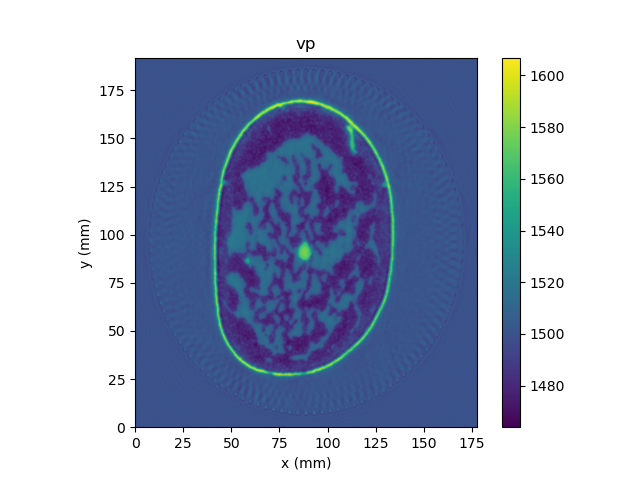

<AxesSubplot:title={'center':'vp'}, xlabel='x (mm)', ylabel='y (mm)'>

In [14]:
from stride import OptimisationLoop

# Clear the previous Devito operators
await pde.clear_operators()

optimisation_loop = OptimisationLoop()

# Specify a series of frequency bands, which we will introduce gradually 
# into the inversion in order to better condition it
f_min = 0.05e6
max_freqs = [0.3e6, 0.4e6]

num_blocks = len(max_freqs)
num_iters = 4

# Start iterating over each block in the optimisation
for block, f_max in optimisation_loop.blocks(num_blocks, max_freqs):

    # Proceed through every iteration in the block
    for iteration in block.iterations(num_iters):
        runtime.logger.info('Starting iteration %d (out of %d), '
                            'block %d (out of %d)' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks))

        # Select some shots for this iteration
        shot_ids = problem.acquisitions.select_shot_ids(num=15, randomly=True)

        # Clear the gradient buffers of the variable
        vp.clear_grad()

        # Asynchronously loop over all the selected shot IDs
        @runtime.async_for(shot_ids)
        async def loop(worker, shot_id):
            runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

            # Fetch one sub-problem corresponding to the shot ID
            sub_problem = problem.sub_problem(shot_id)
            wavelets = sub_problem.shot.wavelets
            observed = sub_problem.shot.observed

            # Pre-process the wavelets
            wavelets = process_wavelets(wavelets, f_min=f_min, f_max=f_max, runtime=worker)
            # Execute the PDE forward
            modelled = pde(wavelets, vp, problem=sub_problem, runtime=worker)

            # Pre-process the modelled and observed traces
            traces = process_traces(modelled, observed, f_min=f_min, f_max=f_max, runtime=worker)
            # and use these pre-processed versions to calculate the
            # value of the loss_freq function
            fun = await loss(traces.outputs[0], traces.outputs[1],
                             problem=sub_problem, runtime=worker).result()

            iteration.add_fun(fun)
            runtime.logger.info('Functional value for shot %d: %s' % (shot_id, fun))

            # Now, we can calculate the gradient by executing the adjoint of the
            # forward process
            await fun.adjoint()

            runtime.logger.info('Retrieved gradient for shot %d' % sub_problem.shot_id)

        # Because this is an async loop, it needs to be awaited    
        _ = await loop
        # Update the vp with the calculated gradient by taking a step with the optimiser
        await optimiser.step()

        runtime.logger.info('Done iteration %d (out of %d), '
                            'block %d (out of %d) - Total loss_freq %e' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks, iteration.fun_value))
        runtime.logger.info('====================================================================')

# Plot the vp afterwards   
vp.plot()

As was the case for the forward example, we can obtain the same result by using a utility function that will run the default inversion workflow using `adjoint`:

In [ ]:
# uncomment to run using utility function
# for block, freq in optimisation_loop.blocks(num_blocks, max_freqs):
#     await adjoint(problem, pde, loss_freq,
#                   optimisation_loop, optimiser, vp,
#                   num_iters=num_iters,
#                   select_shots=dict(num=15, randomly=True),
#                   f_min=0.05e6, f_max=freq)

# vp.plot()

Before closing, we should tear down the mosaic runtime:

In [15]:
await mosaic.interactive('off')